In [1]:
import numpy as np
import pathlib
import math
import tqdm
from  open_ephys import analysis as oea
import scipy.io
from matplotlib import pyplot as plt
from BlockSync_current import *
from OERecording import *
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde

In [2]:
def analyzed_block_automated_pipe(block):
    """This function runs all the import steps that I am already confident about for a block
    that has already gone through synchronization and dlc reading"""
    block.handle_eye_videos()
    block.handle_arena_files()
    block.parse_open_ephys_events()
    #block.synchronize_arena_timestamps()
    #block.create_arena_brightness_df(threshold_value=240,export=True)
    block.synchronize_block(export=True)
    block.create_eye_brightness_df(threshold_value=250)
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.saccade_event_analayzer(threshold=1.5,automatic=True)

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    """
    return np.isnan(y), lambda z: z.nonzero()[0]

def multi_block_saccade_dict_creation_current(blocklist, sampling_window_ms):

    saccade_dict = {}
    # loop over the blocks from here:
    for block in blocklist:
        # collect accelerometer data
        # path definition
        p = block.oe_path / 'analysis'
        analysis_list = os.listdir(p)
        correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
        p = p / str(correct_analysis)
        matPath = p / 'lizMov.mat'
        print(f'path to mat file is {matPath}')
        # read mat file
        mat_data = h5py.File(str(matPath),'r')
        mat_dict = {'t_mov_ms':mat_data['t_mov_ms'][:],
                    'movAll':mat_data['movAll'][:]}

        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:,0],mat_dict['movAll'][:,0]]).T, columns=['t_mov_ms','movAll'])
        #print(mat_data.keys())

        mat_data.close()

        block.saccade_event_analayzer(automatic=True,threshold=2)

        # create the top-level block dict object
        block_dict = {
            'L':{},
            'R':{}
        }

        # create and populate the internal dictionaries (for each eye)
        for i, e in enumerate(['L','R']):
            # get the correct saccades_chunked object and eye_df
            saccades_chunked = [block.l_saccades_chunked,block.r_saccades_chunked][i]
            eye_df = [block.le_df,block.re_df][i]
            saccades = saccades_chunked[saccades_chunked.saccade_length_frames > 0]
            saccade_times = np.sort(saccades.saccade_start_ms.values)
            ep_channel_numbers = [8]
            pre_saccade_ts = saccade_times - (sampling_window_ms / 2) #

            # get the data of the relevant saccade time windows:
            print(f'calling get_data with the following inputs:'
                  f'eye = {e}'
                  f'block = {block}'
                  f'pre_saccade_ts = {pre_saccade_ts} \n'
                  f'sampling_window_ms = {sampling_window_ms}')
            ep_data, ep_timestamps = block.oe_rec.get_data(ep_channel_numbers,pre_saccade_ts, sampling_window_ms, convert_to_mv=True) # [n_channels, n_windows, nSamples]

            # start populating the dictionary
            block_dict[e] = {
                "timestamps":[],
                "fs":[],
                "pxx":[],
                "samples":[],
                "x_coords":[],
                "y_coords":[],
                "vid_inds":[],
                "accel":[]
            }

            # go saccade by saccade
            for j in range(len(pre_saccade_ts)):
                # get specific saccade samples:
                saccade_samples = ep_data[0,j,:] # [n_channels, n_windows, nSamples]
                # get the spectral profile for the segment
                fs, pxx = sig.welch(saccade_samples,block.sample_rate,nperseg=16384,return_onesided=True)

                j0 = pre_saccade_ts[j]
                j1 = pre_saccade_ts[j] + sampling_window_ms
                s_df = eye_df.query("ms_axis >= @j0 and ms_axis <= @j1")
                x_coords = s_df['center_x'].values
                y_coords = s_df['center_y'].values
                vid_inds = np.array(s_df.Arena_TTL.values - s_df.Arena_TTL.values[0], dtype='int32')

                #deal with missing datapoints in saccades:
                interpolated_coords = []
                bad_saccade = False
                for y in [x_coords, y_coords]:
                    nan_count = np.sum(np.isnan(y.astype(float)))
                    if nan_count > 0 :
                        if nan_count < len(y)/2:
                            #print(f'saccade at ind {i} has {nan_count} nans, interpolating...')
                            # find nan values in the vector
                            nans, z = nan_helper(y.astype(float))
                            # interpolate using the helper lambda function
                            y[nans] = np.interp(z(nans),z(~nans),y[~nans].astype(float))
                            # replace the interpolated values for the saccade
                            interpolated_coords.append(y)
                        else:
                            print(f'too many nans at ind {j}, ({np.sum(np.isnan(y))}) - cannot interpolate properly',end='\r',flush=True)
                            bad_saccade = True
                    else:
                        interpolated_coords.append(y)

                # get accelerometer data for the ms_based section:
                # get_ms_segment
                ms_segment = s_df['ms_axis']
                s0 = ms_segment.iloc[0]
                s1 = ms_segment.iloc[-1]
                mov_mag = np.sum(acc_df.query('t_mov_ms > @s0 and t_mov_ms < @s1').movAll.values)

                # remove bad saccades
                if bad_saccade:
                    continue
                # append OK saccades
                else:
                    block_dict[e]['timestamps'].append(pre_saccade_ts[j])
                    block_dict[e]['x_coords'].append(interpolated_coords[0])
                    block_dict[e]['y_coords'].append(interpolated_coords[1])
                    block_dict[e]['vid_inds'].append(vid_inds)
                    block_dict[e]['fs'].append(fs)
                    block_dict[e]['pxx'].append(pxx)
                    block_dict[e]['samples'].append(saccade_samples)
                    block_dict[e]['accel'].append(mov_mag)
        saccade_dict[block.block_num] = block_dict
    return saccade_dict

def sort_synced_saccades(b_dict):
    """
    This function takes a saccades dictionary and returns two sorted dictionaries - one with synced saccades, the other with non-synced saccades
    :param b_dict:
    :return:
    """
    # get the two timestamps vectors
    l_times = np.array(b_dict['L']['timestamps'])
    r_times = np.array(b_dict['R']['timestamps'])

    # I want to collect the matching indices from the L and R dictionaries and create a "synced saccades dict" object that only has two-eyed saccades included in it
    # first, I have to understand which rows of the dictionaries go together:
    # create a matrix of [left eye timestamp, -,left eye ind, -]
    s_mat = np.empty([len(l_times),5])
    s_mat[:,0] = l_times
    s_mat[:,2] = np.arange(0,len(l_times))
    # find and fit the right eye times and indices on columns 1 and 3
    for i, lt in enumerate(s_mat[:,0]):
        array = np.abs((r_times - lt))
        ind_min_diff = np.argmin(array)
        min_diff = array[ind_min_diff]
        rt = r_times[ind_min_diff]
        s_mat[i,3] = ind_min_diff
        s_mat[i,1] = rt
        s_mat[i,4] = min_diff

    # create a dataframe for queries and testing, define a threshold and remove non sync saccades
    s_df = pd.DataFrame(s_mat,columns=['lt','rt','left_ind','right_ind','diff'])
    threshold = 1400 # 70 ms to consider a saccade simultaneous
    s_df = s_df.query('diff<@threshold')
    ind_dict = {
        'L':s_df['left_ind'].values,
        'R':s_df['right_ind'].values
    }

    # create a synced dictionary for the block:
    synced_b_dict = {
        'L':{},
        'R':{}
    }
    for e in ['L','R']:
        inds = ind_dict[e].astype(int)
        synced_b_dict[e] = {
            "timestamps":np.array(b_dict[e]['timestamps'])[inds],
            "fs":np.array(b_dict[e]['fs'])[inds],
            "pxx":np.array(b_dict[e]['pxx'])[inds],
            "samples":np.array(b_dict[e]['samples'])[inds],
            "x_coords":np.array(b_dict[e]['x_coords'])[inds],
            "y_coords":np.array(b_dict[e]['y_coords'])[inds],
            "vid_inds":np.array(b_dict[e]['vid_inds'])[inds],
            "accel":np.array(b_dict[e]['accel'])[inds]
        }

    non_sync_b_dict = {
        'L':{},
        'R':{}
    }
    for e in ['L','R']:
        inds = ind_dict[e].astype(int)
        logical = np.ones(len(b_dict[e]['timestamps'])).astype(np.bool)
        logical[inds] = 0
        non_sync_b_dict[e] = {
            "timestamps":np.array(b_dict[e]['timestamps'])[logical],
            "fs":np.array(b_dict[e]['fs'])[logical],
            "pxx":np.array(b_dict[e]['pxx'])[logical],
            "samples":np.array(b_dict[e]['samples'])[logical],
            "x_coords":np.array(b_dict[e]['x_coords'])[logical],
            "y_coords":np.array(b_dict[e]['y_coords'])[logical],
            "vid_inds":np.array(b_dict[e]['vid_inds'])[logical],
            "accel":np.array(b_dict[e]['accel'])[logical]
        }
    return synced_b_dict, non_sync_b_dict

In [30]:
#blocklist = block_generator(block_numbers,pathlib.Path(r"Z:\Nimrod\experiments"),'PV_62',bad_blocks=bad_blocks)
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_list = [i for i in range(72,76)]
bad_blocks = [42, 62, 64]
p = pathlib.Path(experiment_path) / animal
date_folder_list = [i for i in p.iterdir() if 'block' not in str(i).lower() and i.is_dir()]
block_collection = []
for date_path in date_folder_list:
    date = date_path.name
    # list all the blocks in the folder:
    folder_list = [i for i in date_path.iterdir()]
    for block in folder_list:
        if 'block' in str(block):
            block_number = block.name[-3:]
            if int(block_number) in block_list and int(block_number) not in bad_blocks:
                #block definition
                b = BlockSync(animal_call=animal,
                                  experiment_date=date,block_num=block_number,
                                  path_to_animal_folder=str(experiment_path),regev=True)
                block_collection.append(b)
blockdict = {}
for b in block_collection:
    b_num = b.block_num
    blockdict[b_num] = b

instantiated block number 072 at Path: Z:\Nimrod\experiments\PV_62\2023_06_21\block_072, new OE version
Found the sample rate for block 072 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 072
got it!
instantiated block number 073 at Path: Z:\Nimrod\experiments\PV_62\2023_06_21\block_073, new OE version
Found the sample rate for block 073 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 073
got it!
instantiated block number 074 at Path: Z:\Nimrod\experiments\PV_62\2023_06_21\block_074, new OE version
Found the sample rate for block 074 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 074
got it!
instantiated block number 075 at Path: Z:\Nimrod\experi

In [31]:
for block in block_collection:
    print(block)
    if (block.analysis_path / 'eye_brightness_values_dict.pkl').is_file():
        block.get_eye_brightness_vectors()


PV_62, block 072, on 2023-06-21_14-31-03
PV_62, block 073, on 2023-06-21_14-45-37
PV_62, block 074, on 2023-06-21_15-05-38
PV_62, block 075, on 2023-06-21_15-25-44


In [32]:
for block in block_collection:
    analyzed_block_automated_pipe(block)

handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_072\\eye_videos\\LE\\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim1.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_072\\eye_videos\\RE\\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim1.h264']
The file Z:\Nimrod\experiments\PV_62\2023_06_21\block_072\eye_videos\RE\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\230621_pv62_audiostim1.mp4 already exists, no conversion necessary
Validating videos...
The video named 230621_pv62_audiostim1_LE.mp4 has reported 47995 frames and has 47995 frames, it has dropped 0 frames
The video named 230621_pv62_audiostim1.mp4 has reported 48000 frames and has 48000 frames, it has dropped 0 frames
handling arena files
no arena timestamps folder found
Arena video Names:
back_20230621T143120.mp4
left_20230621T143120.mp4
right_20230621T143120.mp4
top_

In [18]:
# function variables:
sampling_window_ms = 2000 # milliseconds (THIS SHOULD BE IN THE FUNCTION CALL!!!!)


saccade_dict = multi_block_saccade_dict_creation_current(block_collection[:], sampling_window_ms=sampling_window_ms)


path to mat file is Z:\Nimrod\experiments\PV_62\2023_06_21\block_072\oe_files\2023-06-21_14-31-03\Record Node 108\analysis\recNames=Block0072,Animal=PV_62\lizMov.mat
loaded chunked saccade data from analysis folder
calling get_data with the following inputs:eye = Lblock = PV_62, block 072, on 2023-06-21_14-31-03pre_saccade_ts = [ 41978.5   43252.6   44764.7   55451.7   61176.55  64353.55  64659.4
  71965.85 104672.8  104859.7  107918.3  108207.2  108733.95 121697.75
 121833.65 167822.1  170964.35 181053.75 193062.6  196596.1  197496.6
 313384.9  315712.55 340260.15 341891.2  374225.5  374310.4  374378.4
 374480.3  374769.05 375737.35 377588.85 377979.65 379814.3  384027.25
 384417.9  384502.9  396106.2  396208.1  404888.9  406111.95 406213.9
 406417.75 406553.7  417426.   434023.95 442771.8  562042.15 755083.85] 
sampling_window_ms = 2000
sample removed for window #46
The requested data segment between 14721 ms and [[16721.]] ms exceeds the recording length, and will be 0-padded to fit

In [19]:
all_sync_dict = {}
non_sync_dict = {}
for k in saccade_dict.keys():
    k_dict = saccade_dict[k]
    sync_saccades, non_sync_saccades = sort_synced_saccades(k_dict)
    all_sync_dict[k] = sync_saccades
    non_sync_dict[k] = non_sync_saccades

<ipython-input-2-0f49ae986326>:342: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "x_coords":np.array(b_dict[e]['x_coords'])[inds],
<ipython-input-2-0f49ae986326>:343: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "y_coords":np.array(b_dict[e]['y_coords'])[inds],
<ipython-input-2-0f49ae986326>:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the n

In [20]:
def saccade_before_after(coords):
    max_ind = np.argmax(coords)
    min_ind = np.argmin(coords)
    if max_ind < min_ind:
        before = coords[max_ind]
        after = coords[min_ind]
    else:
        before = coords[min_ind]
        after = coords[max_ind]
    delta = after-before
    return before, after, delta

def saccade_dict_enricher(saccade_dict):
    for k in saccade_dict.keys():
        sync_saccades = saccade_dict[k]
        for e in ['L','R']:
            sync_saccades[e]['x_speed'] = []
            sync_saccades[e]['y_speed'] = []
            sync_saccades[e]['magnitude'] = []
            sync_saccades[e]['dx'] = [] # TEMP
            sync_saccades[e]['dy'] = [] # TEMP
            sync_saccades[e]['direction'] = []

            for s in range(len(sync_saccades[e]['timestamps'])):
                # speed:
                sync_saccades[e]['x_speed'].append(np.insert(np.diff(sync_saccades[e]['x_coords'][s]),0,float(0)))
                sync_saccades[e]['y_speed'].append(np.insert(np.diff(sync_saccades[e]['y_coords'][s]),0,float(0)))

                #Understand directionality and magnitude:
                # understand before and after
                x_before, x_after, dx = saccade_before_after(sync_saccades[e]['x_coords'][s])
                y_before, y_after, dy = saccade_before_after(sync_saccades[e]['y_coords'][s])

                # calculate magnitude (euclidean)
                s_mag = np.sqrt(dx**2 + dy**2)

                # get direction quadrant
                if dx > 0 and dy > 0:
                    quad = 0
                elif dx < 0 < dy:
                    quad = 1
                elif dx<0 and dy<0:
                    quad = 2
                elif dx > 0 > dy:
                    quad = 3
                # get direction (theta calculated from quadrent border)
                degrees_in_quadrent = np.rad2deg(np.arctan(np.abs(dy)/np.abs(dx)))
                theta = degrees_in_quadrent + (quad*90)

                # collect into dict
                sync_saccades[e]['dx'].append(dx)
                sync_saccades[e]['dy'].append(dy)
                sync_saccades[e]['magnitude'].append(s_mag)
                sync_saccades[e]['direction'].append(theta)
        saccade_dict[k] = sync_saccades
    return saccade_dict

In [21]:
all_sync_dict = saccade_dict_enricher(all_sync_dict)
non_sync_dict = saccade_dict_enricher(non_sync_dict)


In [22]:
def parse_dataset_to_df(saccade_dict,blocklist):

    date_list = [block.oe_dirname[-19:] for block in blocklist]
    num_list = [block.block_num for block in blocklist]
    num_date_dict = dict(zip(num_list,date_list))
    df = pd.DataFrame(columns=['datetime','block','eye','timestamps', 'fs', 'pxx', 'samples', 'x_coords', 'y_coords', 'vid_inds', 'x_speed', 'y_speed', 'magnitude', 'dx', 'dy', 'direction','accel'])
    d = saccade_dict
    index_counter = 0
    for k in d.keys():
        block = d[k] # in a certain block
        for e in block.keys():
            eye = block[e] #in one of the eyes
            for row in range(len(eye['samples'])): # for each saccade
                for col in eye.keys(): # for each columm
                    v = eye[col][row] # get value of location
                    df.at[index_counter,'block'] = k
                    df.at[index_counter,'eye'] = e
                    df.at[index_counter,'datetime'] = num_date_dict[k]
                    df.at[index_counter,col] = v
                print(index_counter,end='\r',flush=True)
                index_counter +=1
    print(f'done, dataframe contains {index_counter} saccades')
    return df

In [23]:
all_sync_df = parse_dataset_to_df(all_sync_dict,blocklist=block_collection)
non_sync_df = parse_dataset_to_df(non_sync_dict,blocklist=block_collection)

done, dataframe contains 34 saccades
done, dataframe contains 157 saccades


In [24]:
for block in block_collection:
    block.calibrate_pixel_size(10)

got the calibration values from the analysis folder
got the calibration values from the analysis folder
got the calibration values from the analysis folder


In [25]:
### deal with pixel to real distance conversion here:
# This is based on a measured distance but I'm not sure which I used! So this needs to happen again...
# all_sync_df.insert(loc=len(all_sync_df.columns),column='calib_dx',value=None)
# all_sync_df.insert(loc=len(all_sync_df.columns),column='calib_dy',value=None)

blockdict = {}
for b in block_collection:
    b_num = b.block_num
    blockdict[b_num] = b

for ind in tqdm(range(len(all_sync_df))):
    block_num = all_sync_df['block'][ind]
    L_calib_factor = blockdict[block_num].L_pix_size
    R_calib_factor = blockdict[block_num].R_pix_size
    if all_sync_df['eye'][ind] == 'L':
        all_sync_df.at[ind, 'calib_dx'] = all_sync_df['dx'][ind]*L_calib_factor
        all_sync_df.at[ind, 'calib_dy'] = all_sync_df['dy'][ind]*L_calib_factor
    else:
        all_sync_df.at[ind, 'calib_dx'] = all_sync_df['dx'][ind]*R_calib_factor
        all_sync_df.at[ind, 'calib_dy'] = all_sync_df['dy'][ind]*R_calib_factor


100%|██████████| 34/34 [00:00<?, ?it/s]


In [26]:
blockdict = {}
for b in block_collection:
    b_num = b.block_num
    blockdict[b_num] = b

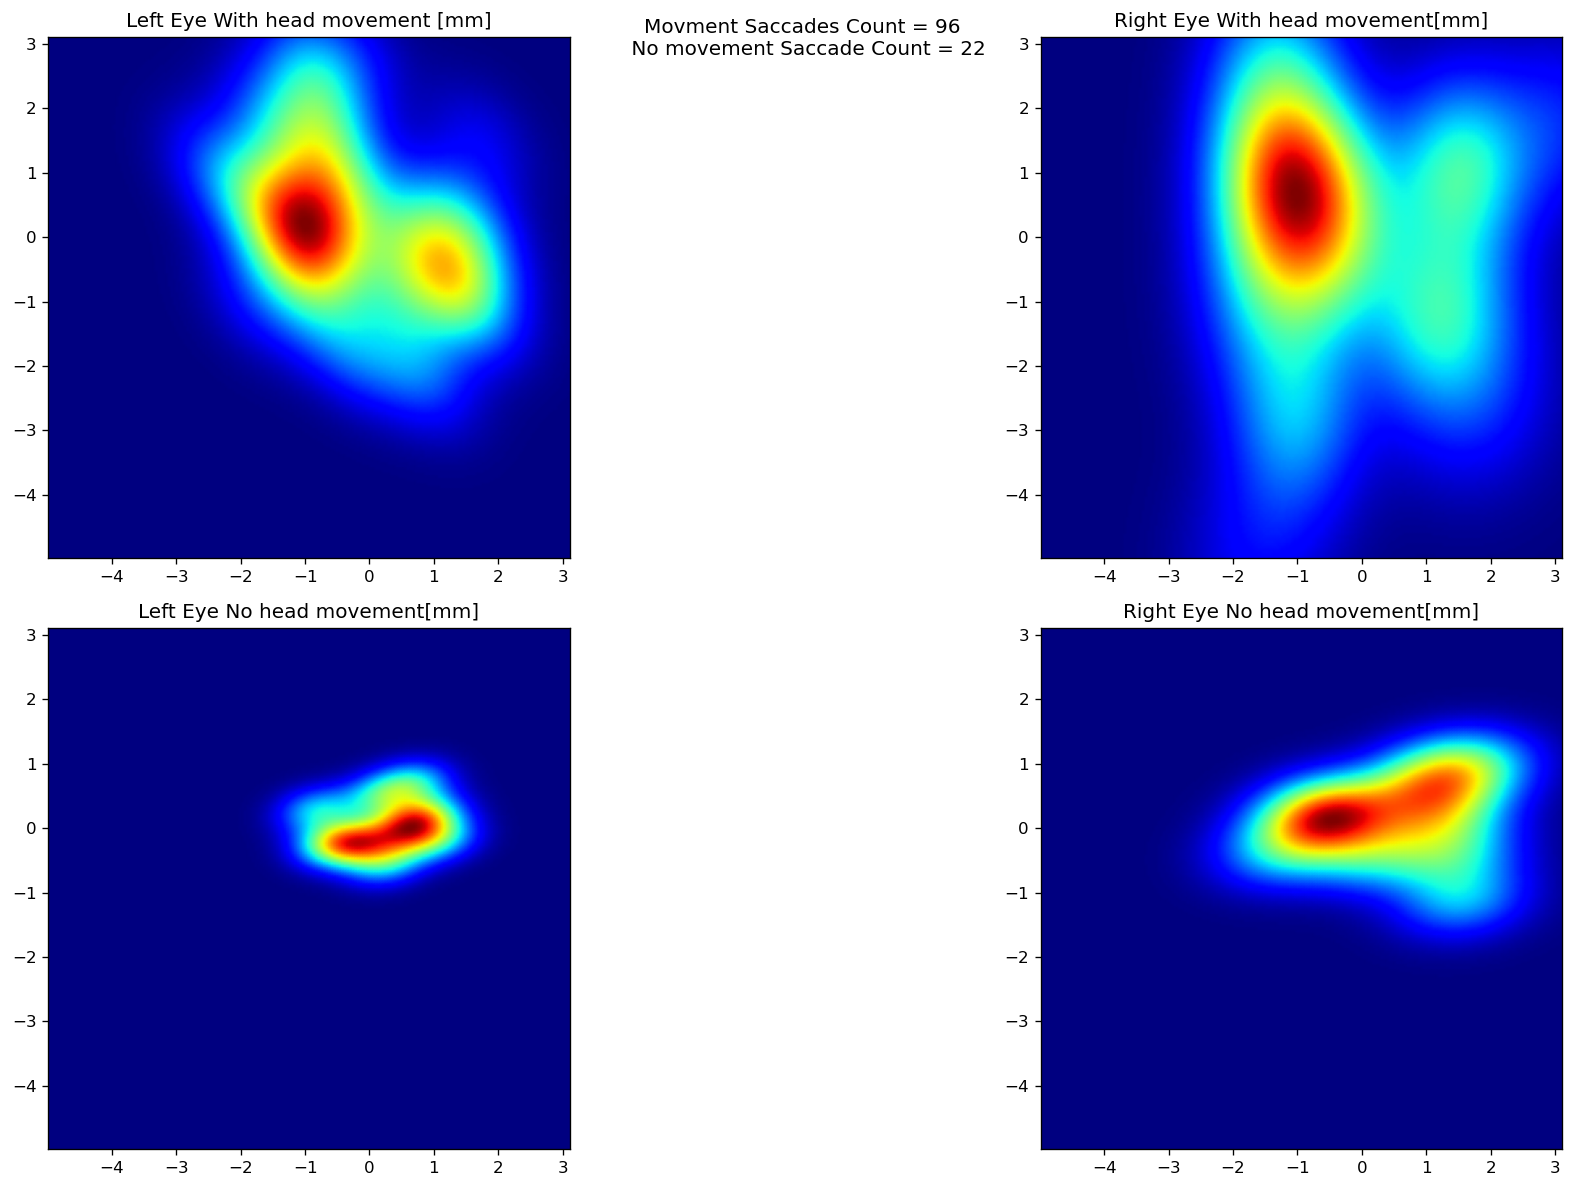

In [25]:
def plot_kde(ax, x, y, nbins, title, xlim=False, ylim=False, global_max=None, global_min=None):
    k = kde.gaussian_kde(np.array([x,y]).astype(np.float))

    if global_max and global_min:
        minimal_coordinate= global_min
        maximal_coordinate = global_max
    else:
        minimal_coordinate= min([x.min(),y.min()])
        maximal_coordinate = max([x.max(),y.max()])
    xi, yi = np.mgrid[minimal_coordinate:maximal_coordinate:nbins*1j, minimal_coordinate:maximal_coordinate:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    ax.set_title(str(title))
    sp = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_aspect('equal','box')
    return sp

#id_list=['012']
id_list = blockdict.keys()
single_df = all_sync_df.query("block.isin(@id_list)")

# I can now query the data I want to analyze, let's take all the 0 accel magnitude saccades:
no_accel_df = single_df.query("accel == 0")
all_accel_df = single_df.query("accel != 0")

# I can produce the KDE graphs for them:
# parse queries:
la_x = all_accel_df.query('eye == "L"')['calib_dx']
la_y = all_accel_df.query('eye == "L"')['calib_dy']
ra_y = all_accel_df.query('eye == "R"')['calib_dy']
ra_x = all_accel_df.query('eye == "R"')['calib_dx']

ln_x = no_accel_df.query('eye == "L"')['calib_dx']
ln_y = no_accel_df.query('eye == "L"')['calib_dy']
rn_y = no_accel_df.query('eye == "R"')['calib_dy']
rn_x = no_accel_df.query('eye == "R"')['calib_dx']

#understand graph bounderies:
x_stack = np.concatenate([la_x,ra_x,ln_x,rn_x])
y_stack = np.concatenate([la_y,ra_y,ln_y,rn_y])
global_max = np.max(np.concatenate([x_stack,y_stack]))
global_min = np.min(np.concatenate([x_stack,y_stack]))

#xlim = (np.min(x_stack), np.max(x_stack))
#ylim = (np.min(y_stack), np.max(y_stack))

# create the graph
fig, axes = plt.subplots(ncols=2, nrows=2, figsize =(10*2,5*2), dpi=120)
plot_kde(axes[0,0],la_x,la_y,200,'Left Eye With head movement [mm]',global_max=global_max,global_min=global_min)
plot_kde(axes[0,1],ra_x,ra_y,200,'Right Eye With head movement[mm]',global_max=global_max,global_min=global_min)
plot_kde(axes[1,0],ln_x,ln_y,200,'Left Eye No head movement[mm]',global_max=global_max,global_min=global_min)
plot_kde(axes[1,1],rn_x,rn_y,200,'Right Eye No head movement[mm]',global_max=global_max,global_min=global_min)
fig.suptitle(f"Movment Saccades Count = {len(all_accel_df)} \n No movement Saccade Count = {len(no_accel_df)}")
fig.tight_layout()
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\research_proposal\')

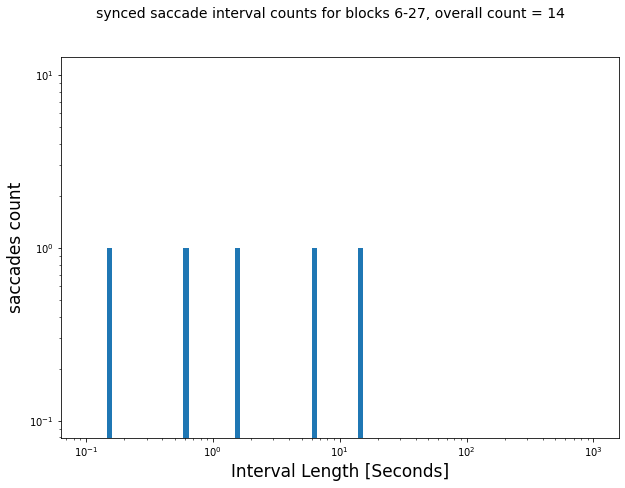

In [28]:
# create a count graph of saccade intervals
saccade_intervals = []
for k in all_sync_dict.keys():
    k_dict = all_sync_dict[k]['L'] # since i am only taking intervals from synced saccades the eye shouldn't matter
    k_intervals = np.diff(k_dict['timestamps'][:]) / block.sample_rate
    saccade_intervals.append(k_intervals)
all_intervals = np.hstack(saccade_intervals)

fig,ax = plt.subplots(figsize=(10,7))
ax.hist(all_intervals,bins=np.geomspace(0.1,1000,100),log=True,rwidth=1)
fig.suptitle(f'synced saccade interval counts for blocks 6-27, overall count = {len(all_intervals)}',fontsize=14)
ax.set_xlabel('Interval Length [Seconds]')
ax.set_xscale('log')
ax.set_ylabel('saccades count')
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)
# save the figure
#plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\synced_saccade_interval_counts_for_blocks_6_27.png')

In [84]:
(block.oe_rec.allTimeStamps[0][-1] + block.oe_rec.globalStartTime_ms) - np.array(block.final_sync_df.Arena_TTL.values / 20)[-1]

array([[13776.5]])

In [83]:
a = np.array([block.final_sync_df.Arena_TTL.values / 20, block.ms_axis])
block.oe_rec.allTimeStamps

array([[0.0000000e+00, 5.1200000e+01, 1.0240000e+02, ..., 1.1754496e+06,
        1.1755008e+06, 1.1755520e+06]])

In [92]:
block.oe_events.Arena_TTL.values[0]
block.oe_rec.globalStartTime_ms * (block.sample_rate/1000)

array([[17548544.]])

In [91]:
block.

BlockSync object for animal PV_62 with 
block_num 073 at date 2023-06-21_14-45-37

In [72]:
first_block_zero = block_collection[0].zeroth_sample_number

second_block_zero = block_collection[1].zeroth_sample_number
third_block_zero = block_collection[2].zeroth_sample_number
for b in block_collection:
    print(b.zeroth_sample_number / 20)

4019.2
877427.2
2078489.6
6604.8


In [36]:
def get_data(self, channels, start_time_ms, window_ms, convert_to_mv=True, return_timestamps=True):
    """
    This is a translated matlab function that efficiently retrieves data from Open-Ephys format neural recordings
    :param self: an OERecording class obj. with a metadata file created by the matlab class with the same name
    :param channels: a vector of channel numbers to sample from [1XN channels]
    :param start_time_ms: a vector of window start times [1XN] in ms
    :param window_ms: a single value, the length of the sampling window from each startTime [ms_value]
    :param convert_to_mv: when True, turns the output into the mV representation of the sampled data
    :param return_timestamps: when True, the output will include sample timestamps from 0 in ms
    :return: data_matrix - an array with the shape [n_channels, n_windows, nSamples] with int16 / mV values
    """
    window_samples = int(
        np.round(window_ms / self.sample_ms))  # round the time in ms to the nearest whole sample count
    n_windows = len(start_time_ms)  # get the number of start times provided
    start_time_ms = np.round(
        start_time_ms / self.sample_ms) * self.sample_ms  # round the start times to the nearest whole sample step
    window_ms = window_samples * self.sample_ms  # get the ms based length of the rounded window

    # deal with the channel numbers:
    if len(channels) == 0 or channels is None:  # if no channels were provided
        channels = self.channelNumbers

    if not all([c in self.channelNumbers for c in channels]):  # if requested channels do not exist in the file
        raise ValueError('one or more of the entered channels does not exist in the recording!')
    n_ch = len(channels)

    # initialize some variables for the data extraction:
    # waveform matrix:
    data_matrix = np.zeros(shape=(int(window_samples), n_windows, n_ch),
                           dtype=self.blkCont['Types'][3],
                           order='F')
    # List to store the record indices for waveform extraction:
    p_rec_idx = []
    # List to store the indices where reading from the file should start (one per reading window):
    read_start_indices = []
    records_per_trial_list = []
    for i in range(n_windows):
        print(i)
        # find the relevant record blocks in the block list:
        p_single_trial_time_stamps = np.where((self.allTimeStamps[0] >= (start_time_ms[0][i] - self.recordLength)) &
                                              (self.allTimeStamps[0] < (start_time_ms[0][i] + window_ms)))[1]
        print(p_single_trial_time_stamps)
        # this collects the indices to start reading from
        read_start_indices.append(p_single_trial_time_stamps[0])


        # Calculate time stamps in milliseconds based on sampling freq & record block length
        single_trial_time_stamps = np.round(self.allTimeStamps[0][
                                                p_single_trial_time_stamps] / self.sample_ms) * self.sample_ms
        # Get the number of records per trial & append to a list
        records_per_trial = len(single_trial_time_stamps[0])
        records_per_trial_list.append(records_per_trial)

        # get the real time values for each sample index:
        time_idx = np.tile((np.arange(self.dataSamplesPerRecord) * self.sample_ms).reshape(-1, 1),
                           (1, records_per_trial)) + single_trial_time_stamps.reshape(1, -1)
        # Find time indices within the requested time window
        # (chunks are 1024 in size so they are usually cut for most time windows, result is as a boolean matrix)
        p_rec_idx.append((time_idx >= start_time_ms[0][i]) & (time_idx < (start_time_ms[0][i] + window_ms)))

        # Due to rounding issues, there may be an error when there is one sample too much -
        # in this case the last sample is removed
        if np.sum(p_rec_idx[i]) == window_samples + 1:
            print(f'sample removed for window #{i}')
            p_rec_idx[i][0, np.where(p_rec_idx[i][0, :] == 1)[0][0]] = False

    p_rec_idx = np.hstack(p_rec_idx)  # Concatenate record indices into a single array

    # now for the data extraction itself:
    for i in range(n_ch):  # iterate over channels
        data = np.zeros(p_rec_idx.shape, dtype=np.dtype('>i2'))  # Initialize the data array for a specific channel
        curr_rec = 0  # for this channel, initialize the record counter
        c_file = self.oe_file_path / self.channel_files[channels[i] - 1]  # get path of current channel file
        with open(c_file, 'rb') as fid:  # open the file such that it will close when left alone
            for j in range(n_windows):  # Iterate over sampling windows
                # use seek to go to the appropriate position in the file
                fid.seek(int(self.headerSizeByte + (read_start_indices[j] * self.bytesPerRecCont) + np.sum(
                    self.blkBytesCont[0:3])), 0)
                # calculate the skip size, cut in half because each int16 is 2 bytes and the matlab
                # function takes bytes as skip (which fromfile does not, uniform datatype)
                skip_size = int(self.bytesPerRecCont[0][0] - self.blkBytesCont[3][0]) // 2
                read_size = self.dataSamplesPerRecord
                # calculate total element count to read:
                total_bytes = (read_size + skip_size) * records_per_trial_list[j]
                # read data from file in a single vector, including skip_data:
                # (Notice datatype is non-flexible in this version of the function!!!)
                data_plus_breaks = np.fromfile(fid, dtype=np.dtype('>i2'), count=total_bytes, sep='')
                # reshape into an array with a column-per-record shape:
                data_plus_breaks = data_plus_breaks.reshape(int(records_per_trial_list[j]), read_size + skip_size)
                # slice the array to get rid of the skip_data at the end of each column (record):
                clean_data = data_plus_breaks[:, : read_size]
                # transpose and store the current_rec data:
                data[:, curr_rec: curr_rec + records_per_trial_list[j]] = clean_data.T
                curr_rec = curr_rec + records_per_trial_list[j]  # move forward to the next reading window
        # this loop exit closes the current channel file
        # vectorize the data from the channel and perform a boolean snipping of non-window samples:
        data_vec = data.T[p_rec_idx.T]

        # put the data in the final data_matrix waveform matrix:
        # check for end-of-recording exceedance :
        if len(data_vec) < int(window_samples) * n_windows:
            print(f'The requested data segment between {read_start_indices [j]} ms and '
                  f'{read_start_indices[j] + window_ms} ms exceeds the recording length, '
                  f'and will be 0-padded to fit the other windows')
            num_zeros = (int(window_samples) * n_windows) - len(data_vec)
            data_vec = np.pad(data_vec,(0, num_zeros), mode='constant')
        data_matrix[:, :, i] = data_vec.reshape(int(window_samples), n_windows, order='F')

    data_matrix = np.transpose(data_matrix, [2, 1, 0])

    if convert_to_mv:
        data_matrix = data_matrix * self.MicrovoltsPerAD[0]

    if return_timestamps:
        timestamps = np.tile(np.arange(window_samples) * self.sample_ms, (n_windows, 1))
        start_times = np.tile(start_time_ms.T, window_samples)
        timestamps = timestamps + start_times
        return data_matrix, timestamps
    else:
        return data_matrix

In [21]:
b

array([ 23618.9 ,  23635.9 ,  23652.9 , ..., 548356.95, 548373.9 ,
       548390.9 ])

In [114]:
pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:,0],mat_dict['movAll'][:,0]]).T, columns=['t_mov_ms','movAll'])

,t_mov_ms,movAll
0,73032.0,10950.945187
1,73036.0,11873.337628
2,73040.0,12821.427499
3,73044.0,13786.798272
4,73048.0,14761.033420
...,...,...
4265,558444.0,36369.811369
4266,558448.0,31347.361650
4267,558452.0,25891.303132
4268,558456.0,20223.557981


In [33]:
eye_df = block.le_df
saccades = block.l_saccades_chunked[block.l_saccades_chunked.saccade_length_frames > 0]
saccade_times = np.sort(saccades.saccade_start_ms.values)
sampling_window_ms = 2000 # ms
pre_saccade_ts = saccade_times - (sampling_window_ms / 2)
ep_data = block.oe_rec.get_data([17],pre_saccade_ts, sampling_window_ms,convert_to_mv=True)


sample removed 16
sample removed 38
sample removed 39
The requested data segment between 10643 ms and [[12643.]] ms exceeds the recording length, and will be 0-padded to fit the other windows


In [4]:
for block in block_collection:
    block.handle_eye_videos()
    block.handle_arena_files()


handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_04_24\\block_013\\eye_videos\\LE\\pv_62_24_trial4_640x480_60hz_experiment_1_recording_0\\pv_62_24_trial4.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_04_24\\block_013\\eye_videos\\RE\\pv_62_24_trial4_640x480_60hz_experiment_1_recording_0\\pv_62_24_trial4.h264']
The file Z:\Nimrod\experiments\PV_62\2023_04_24\block_013\eye_videos\RE\pv_62_24_trial4_640x480_60hz_experiment_1_recording_0\pv_62_24_trial4.mp4 already exists, no conversion necessary
Validating videos...
The video named pv_62_24_trial4_LE.mp4 has reported 69275 frames and has 69275 frames, it has dropped 0 frames
The video named pv_62_24_trial4.mp4 has reported 69383 frames and has 69383 frames, it has dropped 0 frames
handling arena files
no arena timestamps folder found
Arena video Names:
back_20230424T174811.mp4
left_20230424T174811.mp4
right_20230424T174811.mp4
top_20230424T174811.mp4
handling eye video files
converting 

In [27]:
for block in block_collection:
    if int(block.block_num) > 61 :
        block.handle_eye_videos()
        block.handle_arena_files()
        block.parse_open_ephys_events(align_to_zero=True)
        block.synchronize_block(export=True)

handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_05_09\\block_063\\eye_videos\\LE\\20230509_pv62_trial4_640x480_60hz_experiment_1_recording_0\\20230509_pv62_trial4.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_05_09\\block_063\\eye_videos\\RE\\20230509_pv62_trial4_640x480_60hz_experiment_1_recording_0\\20230509_pv62_trial4.h264']
The file Z:\Nimrod\experiments\PV_62\2023_05_09\block_063\eye_videos\RE\20230509_pv62_trial4_640x480_60hz_experiment_1_recording_0\20230509_pv62_trial4.mp4 already exists, no conversion necessary
Validating videos...
The video named 20230509_pv62_trial4_LE.mp4 has reported 199615 frames and has 199616 frames, it has dropped -1 frames
The video named 20230509_pv62_trial4.mp4 has reported 199616 frames and has 199617 frames, it has dropped -1 frames
handling arena files
Arena video Names:
back_20230509T140145.mp4
left_20230509T140145.mp4
right_20230509T140145.mp4
top_20230509T140145.mp4
running parse_open_ephy

  0%|          | 0/228829 [00:00<?, ?it/s]

created Z:\Nimrod\experiments\PV_62\2023_05_11\block_065\oe_files\2023-05-11_12-57-03\parsed_events.csv
creating blocksync_df


100%|██████████| 228829/228829 [09:57<00:00, 382.68it/s]


created blocksync_df
exported blocksync_df to Z:\Nimrod\experiments\PV_62\2023_05_11\block_065\analysis/ blocksync_df.csv
handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_05_11\\block_066\\eye_videos\\LE\\230511_pv62_trial4_640x480_60hz_experiment_1_recording_0\\230511_pv62_trial4.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_05_11\\block_066\\eye_videos\\RE\\230511_pv62_trial4_640x480_60hz_experiment_1_recording_0\\230511_pv62_trial4.h264']
The file Z:\Nimrod\experiments\PV_62\2023_05_11\block_066\eye_videos\RE\230511_pv62_trial4_640x480_60hz_experiment_1_recording_0\230511_pv62_trial4.mp4 already exists, no conversion necessary
Validating videos...
The video named 230511_pv62_trial4_LE.mp4 has reported 192729 frames and has 192729 frames, it has dropped 0 frames
The video named 230511_pv62_trial4.mp4 has reported 192725 frames and has 192725 frames, it has dropped 0 frames
handling arena files
Arena video Names:
back_20230511T14081

  0%|          | 0/188338 [00:00<?, ?it/s]

created Z:\Nimrod\experiments\PV_62\2023_05_11\block_066\oe_files\2023-05-11_14-08-04\parsed_events.csv
creating blocksync_df


100%|██████████| 188338/188338 [07:05<00:00, 442.69it/s]


created blocksync_df
exported blocksync_df to Z:\Nimrod\experiments\PV_62\2023_05_11\block_066\analysis/ blocksync_df.csv
handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_05_18\\block_067\\eye_videos\\LE\\230518_pv62_trial1_640x480_60hz_experiment_1_recording_0\\230518_pv62_trial1.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_05_18\\block_067\\eye_videos\\RE\\230518_pv62_trial1_640x480_60hz_experiment_1_recording_0\\230518_pv62_trial1.h264']
The file Z:\Nimrod\experiments\PV_62\2023_05_18\block_067\eye_videos\RE\230518_pv62_trial1_640x480_60hz_experiment_1_recording_0\230518_pv62_trial1.mp4 already exists, no conversion necessary
Validating videos...
The video named 230518_pv62_trial1_LE.mp4 has reported 130085 frames and has 130085 frames, it has dropped 0 frames
The video named 230518_pv62_trial1.mp4 has reported 129892 frames and has 129892 frames, it has dropped 0 frames
handling arena files
Arena video Names:
back_20230518T11271

  0%|          | 52/126971 [00:00<04:04, 518.34it/s]

created Z:\Nimrod\experiments\PV_62\2023_05_18\block_067\oe_files\2023-05-18_11-26-48\parsed_events.csv
creating blocksync_df


100%|██████████| 126971/126971 [03:49<00:00, 553.52it/s]


created blocksync_df
exported blocksync_df to Z:\Nimrod\experiments\PV_62\2023_05_18\block_067\analysis/ blocksync_df.csv
handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_05_18\\block_068\\eye_videos\\LE\\230518_pv62_trial2_640x480_60hz_experiment_1_recording_0\\230518_pv62_trial2.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_05_18\\block_068\\eye_videos\\RE\\230518_pv62_trial2_640x480_60hz_experiment_1_recording_0\\230518_pv62_trial2.h264']
The file Z:\Nimrod\experiments\PV_62\2023_05_18\block_068\eye_videos\RE\230518_pv62_trial2_640x480_60hz_experiment_1_recording_0\230518_pv62_trial2.mp4 already exists, no conversion necessary
Validating videos...
The video named 230518_pv62_trial2_LE.mp4 has reported 219663 frames and has 219663 frames, it has dropped 0 frames
The video named 230518_pv62_trial2.mp4 has reported 219659 frames and has 219659 frames, it has dropped 0 frames
handling arena files
Arena video Names:
back_20230518T12062

  0%|          | 0/214790 [00:00<?, ?it/s]

created Z:\Nimrod\experiments\PV_62\2023_05_18\block_068\oe_files\2023-05-18_12-06-08\parsed_events.csv
creating blocksync_df


100%|██████████| 214790/214790 [08:51<00:00, 403.85it/s]


created blocksync_df
exported blocksync_df to Z:\Nimrod\experiments\PV_62\2023_05_18\block_068\analysis/ blocksync_df.csv
handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_05_18\\block_069\\eye_videos\\LE\\230518_pv62_trial3_640x480_60hz_experiment_1_recording_0\\230518_pv62_trial3.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_05_18\\block_069\\eye_videos\\RE\\230518_pv62_trial3_640x480_60hz_experiment_1_recording_0\\230518_pv62_trial3.h264']
The file Z:\Nimrod\experiments\PV_62\2023_05_18\block_069\eye_videos\RE\230518_pv62_trial3_640x480_60hz_experiment_1_recording_0\230518_pv62_trial3.mp4 already exists, no conversion necessary
Validating videos...
The video named 230518_pv62_trial3_LE.mp4 has reported 276936 frames and has 276936 frames, it has dropped 0 frames
The video named 230518_pv62_trial3.mp4 has reported 276902 frames and has 276902 frames, it has dropped 0 frames
handling arena files
Arena video Names:
back_20230518T13084

  0%|          | 0/270868 [00:00<?, ?it/s]

created Z:\Nimrod\experiments\PV_62\2023_05_18\block_069\oe_files\2023-05-18_13-08-27\parsed_events.csv
creating blocksync_df


100%|██████████| 270868/270868 [13:50<00:00, 326.29it/s]


created blocksync_df
exported blocksync_df to Z:\Nimrod\experiments\PV_62\2023_05_18\block_069\analysis/ blocksync_df.csv
handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_05_18\\block_070\\eye_videos\\LE\\230518_pv62_trial4_640x480_60hz_experiment_1_recording_0\\230518_pv62_trial4.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_05_18\\block_070\\eye_videos\\RE\\230518_pv62_trial4_640x480_60hz_experiment_1_recording_0\\230518_pv62_trial4.h264']
The file Z:\Nimrod\experiments\PV_62\2023_05_18\block_070\eye_videos\RE\230518_pv62_trial4_640x480_60hz_experiment_1_recording_0\230518_pv62_trial4.mp4 already exists, no conversion necessary
Validating videos...
The video named 230518_pv62_trial4_LE.mp4 has reported 217071 frames and has 217071 frames, it has dropped 0 frames
The video named 230518_pv62_trial4.mp4 has reported 217077 frames and has 217077 frames, it has dropped 0 frames
handling arena files
Arena video Names:
back_20230518T14262

  0%|          | 0/212355 [00:00<?, ?it/s]

created Z:\Nimrod\experiments\PV_62\2023_05_18\block_070\oe_files\2023-05-18_14-26-15\parsed_events.csv
creating blocksync_df


100%|██████████| 212355/212355 [08:33<00:00, 413.71it/s]


created blocksync_df
exported blocksync_df to Z:\Nimrod\experiments\PV_62\2023_05_18\block_070\analysis/ blocksync_df.csv


In [4]:
block = block_collection[1]
block.handle_eye_videos()
block.handle_arena_files()
block.parse_open_ephys_events(align_to_zero=True)
#block.synchronize_arena_timestamps()
#block.create_arena_brightness_df(threshold_value=240,export=True)
block.synchronize_block(export=True)
block.create_eye_brightness_df(threshold_value=250)

handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_073\\eye_videos\\LE\\230621_pv62_audiostim2_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim2.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_073\\eye_videos\\RE\\230621_pv62_audiostim2_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim2.h264']
The file Z:\Nimrod\experiments\PV_62\2023_06_21\block_073\eye_videos\RE\230621_pv62_audiostim2_640x480_60hz_experiment_1_recording_0\230621_pv62_audiostim2.mp4 already exists, no conversion necessary
Validating videos...
The video named 230621_pv62_audiostim2_LE.mp4 has reported 68629 frames and has 68629 frames, it has dropped 0 frames
The video named 230621_pv62_audiostim2.mp4 has reported 68588 frames and has 68588 frames, it has dropped 0 frames
handling arena files
no arena timestamps folder found
Arena video Names:
back_20230621T144553.mp4
left_20230621T144553.mp4
right_20230621T144553.mp4
top_

  1%|          | 381/66814 [00:00<00:17, 3797.36it/s]

created Z:\Nimrod\experiments\PV_62\2023_06_21\block_073\oe_files\2023-06-21_14-45-37\parsed_events.csv
creating blocksync_df


100%|██████████| 66814/66814 [00:27<00:00, 2459.56it/s]


created blocksync_df
exported blocksync_df to Z:\Nimrod\experiments\PV_62\2023_06_21\block_073\analysis/ blocksync_df.csv
working on video Z:\Nimrod\experiments\PV_62\2023_06_21\block_073\eye_videos\LE\230621_pv62_audiostim2_640x480_60hz_experiment_1_recording_0\230621_pv62_audiostim2_LE.mp4
done, frame_val_list contains 1 objects
working on video Z:\Nimrod\experiments\PV_62\2023_06_21\block_073\eye_videos\RE\230621_pv62_audiostim2_640x480_60hz_experiment_1_recording_0\230621_pv62_audiostim2.mp4
done, frame_val_list contains 1 objects
creating Z:\Nimrod\experiments\PV_62\2023_06_21\block_073\analysis/eye_brightness_df.csv


In [3]:
#blocklist = block_generator(block_numbers,pathlib.Path(r"Z:\Nimrod\experiments"),'PV_62',bad_blocks=bad_blocks)
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_list = [i for i in range(69,76)]
bad_blocks = [42, 62, 64]
p = pathlib.Path(experiment_path) / animal
date_folder_list = [i for i in p.iterdir() if 'block' not in str(i).lower() and i.is_dir()]
block_collection = []
for date_path in date_folder_list:
    date = date_path.name
    # list all the blocks in the folder:
    folder_list = [i for i in date_path.iterdir()]
    for block in folder_list:
        if 'block' in str(block):
            block_number = block.name[-3:]
            if int(block_number) in block_list and int(block_number) not in bad_blocks:
                #block definition
                b = BlockSync(animal_call=animal,
                                  experiment_date=date,block_num=block_number,
                                  path_to_animal_folder=str(experiment_path),regev=True)
                block_collection.append(b)
blockdict = {}
for b in block_collection:
    b_num = b.block_num
    blockdict[b_num] = b

instantiated block number 069 at Path: Z:\Nimrod\experiments\PV_62\2023_05_18\block_069, new OE version
Found the sample rate for block 069 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 069
got it!
instantiated block number 070 at Path: Z:\Nimrod\experiments\PV_62\2023_05_18\block_070, new OE version
Found the sample rate for block 070 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 070
got it!
instantiated block number 071 at Path: Z:\Nimrod\experiments\PV_62\2023_06_19\block_071, new OE version
Found the sample rate for block 071 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 071
got it!
instantiated block number 072 at Path: Z:\Nimrod\experi

In [6]:
for block in block_collection:
    analyzed_block_automated_pipe(block)

handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_072\\eye_videos\\LE\\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim1.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_072\\eye_videos\\RE\\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim1.h264']
The file Z:\Nimrod\experiments\PV_62\2023_06_21\block_072\eye_videos\RE\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\230621_pv62_audiostim1.mp4 already exists, no conversion necessary
Validating videos...
The video named 230621_pv62_audiostim1_LE.mp4 has reported 47995 frames and has 47995 frames, it has dropped 0 frames
The video named 230621_pv62_audiostim1.mp4 has reported 48000 frames and has 48000 frames, it has dropped 0 frames
handling arena files
no arena timestamps folder found
Arena video Names:
back_20230621T143120.mp4
left_20230621T143120.mp4
right_20230621T143120.mp4
top_

In [31]:
block.synchronize_block()

blocksync_df loaded from analysis folder


,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame
0,428573.0,620.0,8.0,1.0
1,428913.0,621.0,9.0,2.0
2,429253.0,622.0,10.0,3.0
3,429592.0,623.0,11.0,4.0
4,429932.0,624.0,12.0,5.0
...,...,...,...,...
212350,72517481.0,212970.0,216669.0,216664.0
212351,72517820.0,212971.0,216670.0,216665.0
212352,72518160.0,212972.0,216671.0,216666.0
212353,72518499.0,212973.0,216672.0,216667.0


In [21]:
block = block_collection[0]
block.saccade_event_analayzer()

In [11]:
# get zeroth sample number for event synchronization with EP paradigm of sample#0 = 0:
for block in block_collection:
    block.get_zeroth_sample_number()

retrieving zertoh sample number for block 072
got it!
retrieving zertoh sample number for block 073
got it!
retrieving zertoh sample number for block 074
got it!
retrieving zertoh sample number for block 075
got it!


In [29]:
def align_events_to_zero(block):
    """This function deals with aligning open-ephys events such that the 0th sample is at exactly the record beginning"""

    def subtract_from_columns(df, subtraction_number, column_names):
        # helper function:
        # Create a copy of the DataFrame to avoid modifying the original
        subtracted_df = df.copy()

        # Iterate over the column names in the list
        for column_name in column_names:
            # Check if the column exists in the DataFrame
            if column_name in subtracted_df.columns:
                # Get the indices where the column value is not NaN
                indices = subtracted_df.index[~pd.isna(subtracted_df[column_name])]

                # Subtract the subtraction number from the selected indices
                subtracted_df.loc[indices, column_name] -= subtraction_number

        return subtracted_df

    df = block.oe_events
    df_sub = subtract_from_columns(df,block.zeroth_sample_number, [i for i in df.columns if 'frame' not in i])
    block.oe_events = df_sub


In [21]:
block = block_collection[1]
session = oea.Session(block.oe_path.parent)
events_df = session.recordnodes[0].recordings[0].events


In [16]:
block.oe_path

WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108')

In [77]:
block.oe_rec.globalStartTime_ms*(block.sample_rate / 1000) == block.zeroth_sample_number

array([[ True]])

In [44]:
df = block.oe_events
df_sub = subtract_from_columns(df,block.zeroth_sample_number, [i for i in df.columns if 'frame' not in i])
df_sub

,Arena_TTL,Arena_TTL_frame,LED_driver,LED_driver_frame,L_eye_TTL,L_eye_TTL_frame,R_eye_TTL,R_eye_TTL_frame
1,324.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,663.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1343.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1683.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
290689,16965764.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290691,16966103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290693,16966443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290695,16966783.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df_sub['LED_driver'][df_sub['LED_driver'] == df_sub['LED_driver']]

11805      1198348.0
33305      2399007.0
54811      3599667.0
75838      4800326.0
97345      6000986.0
118848     7201646.0
140351     8402305.0
161857     9602965.0
183360    10803625.0
204865    12004285.0
226368    13204945.0
247871    14405606.0
269375    15606266.0
289753    16806926.0
Name: LED_driver, dtype: float64

In [45]:
df_sub['LED_driver'][df_sub['LED_driver'] == df_sub['LED_driver']]

11805      1198348.0
33305      2399007.0
54811      3599667.0
75838      4800326.0
97345      6000986.0
118848     7201646.0
140351     8402305.0
161857     9602965.0
183360    10803625.0
204865    12004285.0
226368    13204945.0
247871    14405606.0
269375    15606266.0
289753    16806926.0
Name: LED_driver, dtype: float64

In [47]:
session = oea.Session(str(block.oe_path.parent))
rec_node = session.recordnodes[0].recordings[0].continuous[0]
rec_starts = rec_node.timestamps[0]


In [106]:
zeroth_sample_num = [session.recordnodes[0].recordings[0].continuous[0].sample_numbers[0]]
pd.DataFrame({'zeroth_sample_num':zeroth_sample_num}).to_csv(block.analysis_path / 'zeroth_sample_num.csv')


In [110]:
df = pd.read_csv(block.analysis_path / 'zeroth_sample_num.csv')
df['zeroth_sample_num'][0]

80384

In [22]:

for block in block_collection:
    analyzed_block_automated_pipe(block)


handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_072\\eye_videos\\LE\\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim1.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_072\\eye_videos\\RE\\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim1.h264']
The file Z:\Nimrod\experiments\PV_62\2023_06_21\block_072\eye_videos\RE\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\230621_pv62_audiostim1.mp4 already exists, no conversion necessary
Validating videos...
The video named 230621_pv62_audiostim1_LE.mp4 has reported 47995 frames and has 47995 frames, it has dropped 0 frames
The video named 230621_pv62_audiostim1.mp4 has reported 48000 frames and has 48000 frames, it has dropped 0 frames
handling arena files
no arena timestamps folder found
Arena video Names:
back_20230621T143120.mp4
left_20230621T143120.mp4
right_20230621T143120.mp4
top_

In [24]:
block = block_collection[0]
block.final_sync_df

,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,855018.0,1319.0,6.0,11.0,-0.913598,1.884156
1,855358.0,1320.0,7.0,12.0,-0.913155,1.885686
2,855698.0,1321.0,8.0,13.0,-0.912993,1.885833
3,856037.0,1322.0,9.0,14.0,-0.912866,1.884999
4,856377.0,1323.0,10.0,15.0,-0.913932,1.886211
...,...,...,...,...,...,...
46570,16704559.0,47889.0,47562.0,NaN,0.992427,NaN
46571,16704899.0,47890.0,47563.0,NaN,0.992530,NaN
46572,16705239.0,47891.0,47564.0,NaN,0.991791,NaN
46573,16705578.0,47892.0,47565.0,NaN,0.992694,NaN


In [14]:
# initialize some things
#block definition
experiments_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = "PV_62"
date = "2023_04_24"
block_n = "013"

block = BlockSync(animal_call=animal,
                  experiment_date=date,block_num=block_n,
                  path_to_animal_folder=str(experiments_path),regev=True)

# oe session definition (maybe redundent? do I really use their classes?)

oe_metadata_file_path = block.oe_metadata_file_path



instantiated block number 013 at Path: Z:\Nimrod\experiments\PV_62\2023_04_24\block_013, new OE version
Found the sample rate for block 013 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 013
got it!


In [15]:
block.oe_metadata_file_path

WindowsPath('Z:/Nimrod/experiments/PV_62/2023_04_24/block_013/oe_files/2023-04-24_17-47-56/Record Node 108/OE_metaData.mat')

In [17]:
block.parse_open_ephys_events(align_to_zero=True)

running parse_open_ephys_events...
aligning to zero with 48848383
open ephys events aligned to zero & exported to csv file at Z:\Nimrod\experiments\PV_62\2023_04_24\block_013\oe_files\2023-04-24_17-47-56\events.csv
the arena TTLs are signaling start and stop positions at [ 729 6431]
arena first frame timestamp: 308790
arena end frame timestamp: 2245478
L_eye_TTL was not identified as Arena_TTL
R_eye_TTL was not identified as Arena_TTL
created Z:\Nimrod\experiments\PV_62\2023_04_24\block_013\oe_files\2023-04-24_17-47-56\parsed_events.csv


In [ ]:
analyzed_block_automated_pipe(block)
block.calibrate_pixel_size(10,overwrite=True)


In [31]:
# collect saccade events within block
block.saccade_event_analayzer(threshold=2, automatic=False)


WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/OE_metaData.mat')

In [0]:
block.l_saccades_chunked

In [31]:
block.calibrate_pixel_size(10,overwrite=True)


WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/OE_metaData.mat')

In [4]:
class OERecording:
    """
    This is a class designed to get the metadata of an open-ephys format recording that was first analyzed by Mark's matlab code -
    I should probably make an independent function sometime in the future but for now this class reads the produced metadata file to allow efficient access to the recording
    """
    # define a helper function to get a group out of an hdf5 file (without resolving internal references!)

    def group_to_dict(self, group):
        result = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):
                result[key] = self.group_to_dict(item)
            else:

                result[key] = item[()]  # Convert dataset to NumPy array and assign its value
        return result

    def __init__(self, oe_metadata_file_path):
        # create the metadata_dict object:
        # open the mat file:
        mat_file = h5py.File(str(oe_metadata_file_path), 'r')

        #implement on the metaData group:
        meta_dict = self.group_to_dict(mat_file['metaData'])

        # resolve internal references of blkCont object:
        # get to the blkCont mat and reform it from reference instances
        blkCont_dict = {
            'Repeat':[],
            'Types':[],
            'Str':[]
        }
        blkCont_group = mat_file['metaData/blkCont']
        for i in blkCont_group['Repeat']:
            res = np.array(mat_file[i[0]][0])
            blkCont_dict['Repeat'].append(res[0])

        for i in blkCont_group['Types']:
            res = np.array((mat_file[i[0]]))
            str_array = np.vectorize(chr)(res).flatten()
            str_value = ''.join(str_array.flatten())
            blkCont_dict['Types'].append(str_value)

        for i in blkCont_group['Str']:
            res = np.array(mat_file[i[0]])
            str_array = np.vectorize(chr)(res).flatten()
            str_value = ''.join(str_array.flatten())
            blkCont_dict['Str'].append(str_value)

        #close the file
        mat_file.close()

        # switch out the dictionary blkCont attribute
        meta_dict['blkCont'] = blkCont_dict
        # parse a dictionary into attributes of the class
        for key, value in meta_dict.items():
            setattr(self, key, value)
        # add some stuff from Mark's class that's not in the metadata
        self.headerSizeByte = 1024
        self.fileExtension = 'continuous'
        self.eventFileExtension = 'events'
        self.signalBits = 16 # the quantization of the sampling card
        self.dataSamplesPerRecord = 1024
        self.maxTTLBit = 9
        self.oe_file_path = oe_metadata_file_path.parent
        def extract_number_from_file(filename, suffix):
            match = re.search(r'(\d+)\.' + suffix + '$', filename)
            if match:
                return int(match.group(1))
            else:
                return None
        self.channel_files = sorted([i.name for i in oe_metadata_file_path.parent.iterdir() if ('.continuous' in str(i)) & ('AUX' not in str(i)) & ('ADC' not in str(i)) ],
                                    key=lambda x: extract_number_from_file(x, suffix='continuous'))
        self.analog_files = sorted([i.name for i in oe_metadata_file_path.parent.iterdir() if ('AUX' in str(i)) or ('ADC' in str(i))],
                                   key=lambda x: extract_number_from_file(x, suffix='continuous'))

In [9]:
oe_metadata_file_path = pathlib.Path(r'Z:\Nimrod\experiments\PV_62\2023_06_21\block_072\oe_files\2023-06-21_14-31-03\Record Node 108\OE_metaData.mat')
#oe_metadata_file_path = pathlib.Path(r'Z:\Nimrod\experiments\PV_62\2023_06_21\block_073\oe_files\2023-06-21_14-45-37\Record Node 108\OE_metaData.mat')
oe = OERecording(oe_metadata_file_path=oe_metadata_file_path)

In [13]:
oe.analog_files

In [7]:
# TODO: deal with end-of-file errors (right now when encountering the end of a datafile I get numpy broadcasting errors,
#  should be dealt with exceptions and try steps instead.
def get_data_current(oe, channels, startTime_ms, window_ms, convert_to_mV=True):
    """
    This is a translated matlab function that efficiently retrieves data from Open-Ephys format neural recordings
    :param oe: an OERecording class obj. with a metadata file created by the matlab class with the same name
    :param channels: a vector of channel numbers to sample from [1XN channels]
    :param startTime_ms: a vector of window start times [1XN] in ms
    :param window_ms: a single value, the length of the sampling window from each startTime [ms_value]
    :param convert_to_mV: when True, turns the output into the mV representation of the sampled data
    :return: V_uV - an array with the shape [nChannels, nWindows, nSamples] and either the int16 / mV values
    """
    windowSamples = int(np.round(window_ms / oe.sample_ms)) # round the time in ms to the nearest whole sample count
    nWindows = len(startTime_ms) # get the number of start times provided
    startTime_ms = np.round(startTime_ms / oe.sample_ms) * oe.sample_ms # round the start times to the nearest whole sample multiple
    window_ms = windowSamples*oe.sample_ms # get the ms based length of the rounded window

    # deal with the channel numbers:
    if len(channels) == 0 or channels is None: #if no channels were provided
        channels = oe.channelNumbers

    if not all([c in oe.channelNumbers for c in channels]): #if requested channels do not exist in the file
        raise ValueError('one or more of the entered channels does not exist in the recording!')
    nCh = len(channels)

    #initialize some variables for the data extraction:
    V_uV = np.zeros(shape=(int(windowSamples),nWindows,nCh),
                    dtype=oe.blkCont['Types'][3],
                    order='F') #initialize the waveform matrix
    # List to store the record indices for waveform extraction
    p_rec_idx = []
    # List to store the indices where reading from the file should start (one per reading window)
    read_start_indices = []
    records_per_trial_list = []
    for i in range(nWindows):
        # find the relevant record blocks in the block list:
        p_single_trial_time_stamps = np.where((oe.allTimeStamps[0] >= (startTime_ms[0][i] - oe.recordLength)) &
                                              (oe.allTimeStamps[0] < (startTime_ms[0][i] + window_ms)))[1]
        read_start_indices.append(p_single_trial_time_stamps[0]) # this collects the indices to start reading from
        single_trial_time_stamps = np.round(oe.allTimeStamps[0][p_single_trial_time_stamps] / oe.sample_ms) * oe.sample_ms  # Calculate time stamps in milliseconds based on sampling freq & record block length
        records_per_trial = len(single_trial_time_stamps[0])  # Get the number of records per trial
        records_per_trial_list.append(records_per_trial)
        # This is problematic, should give me the right time index selections consistently
        time_idx = np.tile((np.arange(oe.dataSamplesPerRecord) * oe.sample_ms).reshape(-1, 1), (1, records_per_trial)) + single_trial_time_stamps.reshape(1, -1)
        if i==0:
            p_rec_idx.append((time_idx >= startTime_ms[0][i]) & (time_idx < (startTime_ms[0][i] + window_ms)))  # Find time indices within the requested time window (chunks are 1024 in size so they are usually cut for most time windows, this is saved as a boolean matrix)
        else:
            p_rec_idx.append((time_idx >= startTime_ms[0][i]) & (time_idx < (startTime_ms[0][i] + window_ms)))

        if np.sum(p_rec_idx[i]) == windowSamples + 1:  # Due to rounding issues, there may be an error when there is one sample too much - in this case the last sample is removed
            print(f'sample removed {i}')
            p_rec_idx[i][0, np.where(p_rec_idx[i][0, :] == 1)[0][0]] = False

    p_rec_idx = np.hstack(p_rec_idx)  # Concatenate record indices into a single array

    # now for the data extraction itself:
    for i in range(nCh): # iterate over channels
        data = np.zeros(p_rec_idx.shape, dtype=np.dtype('>i2'))  # Initialize the data array for a specific channel
        curr_rec = 0 # for this channel, initialize the record counter
        c_file = oe.oe_file_path / oe.channel_files[channels[i]-1] # get the path to the relevant channel file
        with open(c_file,'rb') as fid: #open the file such that it will close when left alone
            for j in range(nWindows): # Iterate over sampling windows
                # use seek to go to the appropriate position in the file
                fid.seek(int(oe.headerSizeByte + (read_start_indices[j] * oe.bytesPerRecCont) + np.sum(oe.blkBytesCont[0:3])), 0)
                # calculate the skip size, cut in half because each int16 is 2 bytes and the matlab function takes bytes as skip
                # (which fromfile does not, uniform datatype)
                skip_size = int(oe.bytesPerRecCont[0][0] - oe.blkBytesCont[3][0]) // 2
                read_size = oe.dataSamplesPerRecord
                total_bytes = (read_size + skip_size) * records_per_trial_list[j] # calculate total element count to read
                # read data from file in a single vector, including skip_data (Notice datatype is non-flexible in this version of the function!!!)
                data_plus_breaks = np.fromfile(fid, dtype=np.dtype('>i2'), count=total_bytes, sep='')
                data_plus_breaks = data_plus_breaks.reshape(int(records_per_trial_list[j]), read_size + skip_size) # reshape into an array with a column-per-record shape
                clean_data = data_plus_breaks[:, :read_size] # slice the array to get rid of the skip_data at the end of each column (record)
                data[:, curr_rec : curr_rec + records_per_trial_list[j]] = clean_data.T # transpose and store the current_rec data
                curr_rec = curr_rec + records_per_trial_list[j] # move forward to the next reading window
        # this loop exit closes the current channel file
        data_vec = data.T[p_rec_idx.T] # vectorize the data from the channel and perform a boolean snipping of non-window samples
        V_uV[:,:,i] = data_vec.reshape(int(windowSamples), nWindows, order='F') # put the data in the final V_uV waveform matrix

    V_uV = np.transpose(V_uV,[2,1,0])

    if convert_to_mV:
        V_uV = V_uV* oe.MicrovoltsPerAD[0]
        return V_uV
    else:
        return V_uV

In [31]:
def recursive_printer(element):
    txt = ET.tostring(element, pretty_print=True)
    print(str(txt))
    print('#####')
    if len(element) > 1:
        for i in range(len(element)):
            recursive_printer(element[i])

tree = ET.parse(str(xml_path))
root = tree.getroot()
for element in root:
    recursive_printer(element)

WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/OE_metaData.mat')

In [121]:
%%time

data_array = get_data_current(oe,[1],[10000, 20000, 30000],[500000],True)
data_vec = np.concatenate([data_array[0,0,:],data_array[0,1,:],data_array[0,2,:]])
mat_vec = scipy.io.loadmat('Z:/Nimrod/HelperFiles/c_vec.mat')
c_vec = mat_vec['comp_vec'][:,0]
np.array_equal(c_vec,data_vec)

ValueError: cannot reshape array of size 29920173 into shape (10000000,3)

In [110]:
import line_profiler
from IPython.display import display
profiler = line_profiler.LineProfiler()
profiler.add_function(get_data_current)
profiler.run("get_data_current(oe,[1,5,10,20],[10000],[5000],True)")
display(profiler.print_stats(output_unit=1e-4))


Timer unit: 0.0001 s

Total time: 0.0816057 s
File: <ipython-input-16-f63137aa0b36>
Function: get_data_current at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_data_current(oe, channels, startTime_ms, window_ms, convert_to_mV=True):
     2                                               """
     3                                               This is a translated matlab function that efficiently retrieves data from Open-Ephys format neural recordings
     4                                               :param oe: an OERecording class obj. with a metadata file created by the matlab class with the same name
     5                                               :param channels: a vector of channel numbers to sample from [1XN channels]
     6                                               :param startTime_ms: a vector of window start times [1XN] in ms
     7                                               :param wi

None

In [71]:
np.array_equal(c_vec[:,0],data_vec)
#np.shape(c_vec[:,0])

True

In [10]:
# check stuff here:
# rounding the inputs to clean multiples of the sample timestep:
channels=[1]
startTime_ms = [10000, 20000]
window_ms = 5000

windowSamples = int(np.round(window_ms/oe.sample_ms)) # round the time in ms to the nearest whole sample count
nWindows = len(startTime_ms) # get the number of start times provided
startTime_ms = np.round(startTime_ms / oe.sample_ms) * oe.sample_ms # round the start times to the nearest whole sample multiple
window_ms = windowSamples*oe.sample_ms # get the ms based length of the rounded window

# deal with the channel numbers:
if len(channels) == 0 or channels is None: #if no channels were provided
    channels = oe.channelNumbers

if not all([c in oe.channelNumbers for c in channels]): #if requested channels do not exist in the file
    raise ValueError('one or more of the entered channels does not exist in the recording!')
nCh = len(channels)

#initialize some variables for the data extraction:
V_uV = np.zeros(shape=(int(windowSamples),nWindows,nCh), dtype=oe.blkCont['Types'][3], order='F') #initialize the waveform matrix

p_out_idx = []  # List to store the output indices for waveform extraction
p_rec_idx = []  # List to store the record indices for waveform extraction
read_start_indices = [] # List to store the indices where reading from the file should start (one per reading window)
records_per_trial_list = []
for i in range(nWindows):
    # find the relevant blocks in the block list:
    p_single_trial_time_stamps = np.where((oe.allTimeStamps[0] >= (startTime_ms[0][i] - oe.recordLength)) & (oe.allTimeStamps[0] < (startTime_ms[0][i] + window_ms)))[1]
    read_start_indices.append(p_single_trial_time_stamps[0])
    # TODO: deal with the edge case where the start index is at 0
    #
    # if p_single_trial_time_stamps[0] == 0:
    #     read_start_indices.append(p_single_trial_time_stamps[0])
    # else:
    #     read_start_indices.append(p_single_trial_time_stamps[0])

    single_trial_time_stamps = np.round(oe.allTimeStamps[0][p_single_trial_time_stamps] / oe.sample_ms) * oe.sample_ms  # Calculate time stamps in milliseconds
    records_per_trial = len(single_trial_time_stamps[0])  # Get the number of records per trial
    records_per_trial_list.append(records_per_trial)
    # This is problematic, should give me the right time index selections consistently
    time_idx = np.tile((np.arange(oe.dataSamplesPerRecord) * oe.sample_ms).reshape(-1, 1), (1, records_per_trial)) + single_trial_time_stamps.reshape(1, -1)
    if i==0:
        p_rec_idx.append((time_idx >= startTime_ms[0][i]) & (time_idx < (startTime_ms[0][i] + window_ms)))  # Find time indices within the requested time window (chunks are 1024 in size so they are usually cut for most time windows, this is saved as a boolean matrix)
    else:
        p_rec_idx.append((time_idx >= startTime_ms[0][i]) & (time_idx < (startTime_ms[0][i] + window_ms)))

    if np.sum(p_rec_idx[i]) == windowSamples + 1:  # Due to rounding issues, there may be an error when there is one sample too much - in this case the last sample is removed
        print(f'sample removed {i}')
        p_rec_idx[i][0, np.where(p_rec_idx[i][0, :] == 1)[0][0]] = False

    time_idx = time_idx.T
    #p_out_idx.append(np.round((time_idx[p_rec_idx[i].T] - startTime_ms[0][i]) / oe.sample_ms) + windowSamples * i)  # Calculate the output indices for waveform extraction

# if p_out_idx[0][0][0] == -1:  # Special case handling where the first index is 0 (due to rounding) -> might be redundent with python
#     p_out_idx[0] += 1

p_rec_idx = np.hstack(p_rec_idx)  # Concatenate record indices into a single array
# p_out_idx = np.hstack(p_out_idx)  # Concatenate output indices into a single array


# now for the data extraction itself:
# first, iterate over channels:
for i in range(nCh):
    data = np.zeros(p_rec_idx.shape, dtype=np.dtype('>i2'))  # Initialize the data array for a specific channel
    curr_rec = 0
    c_file = oe.oe_file_path / oe.channel_files[channels[i]-1] # get the channel file to read from
    with open(c_file,'rb') as fid: #open the file such that it will close when left alone
        for j in range(nWindows):
            fid.seek(int(oe.headerSizeByte + (read_start_indices[j] * oe.bytesPerRecCont) + np.sum(oe.blkBytesCont[0:3])), 0) # use seek to go to the appropriate position in the file
            skip_size = int(oe.bytesPerRecCont[0][0] - oe.blkBytesCont[3][0]) // 2 # calculate the skip size, cut in half because each int16 is 2 bytes and the matlab function takes bytes as skip
            # (which fromfile does not, uniform datatype)
            read_size = oe.dataSamplesPerRecord
            total_bytes = (read_size + skip_size) * records_per_trial_list[j] # calculate total element count to read
            data_plus_breaks = np.fromfile(fid, dtype=np.dtype('>i2'), count=total_bytes, sep='') # read data from file in a single vector, including skip_data
            data_plus_breaks = data_plus_breaks.reshape(int(records_per_trial_list[j]), read_size + skip_size) # reshape into an array with a column per-record
            clean_data = data_plus_breaks[:, :read_size] # slice the array to get rid of the skip_data
            data[:, curr_rec : curr_rec + records_per_trial_list[j]] = clean_data.T
            curr_rec = curr_rec + records_per_trial_list[j]
    data_vec = data.T[p_rec_idx.T] # vectorize the data and perform a boolean snipping of non-window samples
    if len(data_vec) < int(windowSamples) * nWindows:
        print(f'The requested data segment between {read_start_indices [j]} ms and {read_start_indices[j] + window_ms[0][0]} ms '
              f'exceeds the recording length, and will be 0-padded to fit the other windows')
        num_zeros = (int(windowSamples) * nWindows) - len(data_vec)
        data_vec = np.pad(data_vec,(0, num_zeros), mode='constant')
    V_uV[:,:,i] = data_vec.reshape(int(windowSamples), nWindows, order='F') # put the data in the final V_uV waveform matrix

V_uV = np.transpose(V_uV,[2,1,0])

In [138]:
num_zeros = int(windowSamples)*nWindows - len(data_vec)
padded_data_vec = np.pad(data_vec,(0,num_zeros),mode='constant')
padded_data_vec

array([180, 172, 132, ...,   0,   0,   0], dtype=int16)

In [32]:

timestamps = np.tile(np.arange(windowSamples) * oe.sample_ms,(nWindows,1))
start_times = np.tile(startTime_ms.T,windowSamples)
timestamps = timestamps+start_times
timestamps

array([[10000.  , 10000.05, 10000.1 , ..., 14999.85, 14999.9 , 14999.95],
       [20000.  , 20000.05, 20000.1 , ..., 24999.85, 24999.9 , 24999.95]])

In [26]:
startTime_ms

array([[10000., 20000.]])

In [376]:
# vector comparison
py_vec = data_vec * oe.MicrovoltsPerAD[0]
mat_vec = scipy.io.loadmat(pathlib.Path('Z:/Nimrod/HelperFiles/c_vec.mat'))
c_vec = mat_vec['c_vec']
c_vec = c_vec[:,0]
#c_vec[0] = 111
mat_vec = np.vstack((py_vec,c_vec))

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e-02, 5.000e-02, 5.000e-02, ..., 5.000e-02, 5.000e-02,
        5.000e-02],
       [1.000e-01, 1.000e-01, 1.000e-01, ..., 1.000e-01, 1.000e-01,
        1.000e-01],
       ...,
       [5.105e+01, 5.105e+01, 5.105e+01, ..., 5.105e+01, 5.105e+01,
        5.105e+01],
       [5.110e+01, 5.110e+01, 5.110e+01, ..., 5.110e+01, 5.110e+01,
        5.110e+01],
       [5.115e+01, 5.115e+01, 5.115e+01, ..., 5.115e+01, 5.115e+01,
        5.115e+01]])

In [4]:
mat_vec.T

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [376]:
#p_rec_idx.append((time_idx >= startTime_ms[0][i]) & (time_idx < (startTime_ms[0][i] + window_ms)))
mat_vec.T

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e-02, 5.000e-02, 5.000e-02, ..., 5.000e-02, 5.000e-02,
        5.000e-02],
       [1.000e-01, 1.000e-01, 1.000e-01, ..., 1.000e-01, 1.000e-01,
        1.000e-01],
       ...,
       [5.105e+01, 5.105e+01, 5.105e+01, ..., 5.105e+01, 5.105e+01,
        5.105e+01],
       [5.110e+01, 5.110e+01, 5.110e+01, ..., 5.110e+01, 5.110e+01,
        5.110e+01],
       [5.115e+01, 5.115e+01, 5.115e+01, ..., 5.115e+01, 5.115e+01,
        5.115e+01]])

In [4]:
time_idx.T

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [376]:
read_start_indices

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e-02, 5.000e-02, 5.000e-02, ..., 5.000e-02, 5.000e-02,
        5.000e-02],
       [1.000e-01, 1.000e-01, 1.000e-01, ..., 1.000e-01, 1.000e-01,
        1.000e-01],
       ...,
       [5.105e+01, 5.105e+01, 5.105e+01, ..., 5.105e+01, 5.105e+01,
        5.105e+01],
       [5.110e+01, 5.110e+01, 5.110e+01, ..., 5.110e+01, 5.110e+01,
        5.110e+01],
       [5.115e+01, 5.115e+01, 5.115e+01, ..., 5.115e+01, 5.115e+01,
        5.115e+01]])

In [4]:
a = V_uV * oe.MicrovoltsPerAD[0]
a[0,0,:]

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [4]:
data_tester = V_uV * oe.MicrovoltsPerAD[0]
prec_tester = p_rec_idx
p = pathlib.Path(r'Z:/Nimrod/HelperFiles/dataTester.mat')
scipy.io.savemat(p,{'data':data_tester, 'prec':prec_tester})

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [4]:
#data[np.where(p_rec_idx)]
data_vec = data.flatten('F')[p_rec_idx.flatten('F')]
data_vec.reshape(np.shape(V_uV)[:2],order='F')

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [48]:
print(p_rec_idx.shape)
print(V_uV.shape)
print(data.shape)
print(records_per_trial_list)
a = V_uV.flatten()
a = np.zeros(60000)
int(oe.bytesPerRecCont[0][0] - oe.blkBytesCont[3][0])
oe.headerSizeByte + (read_start_indices[1] * oe.bytesPerRecCont) + np.sum(oe.blkBytesCont[0:3])

array([[  42,  180,  -47],
       [  71,  172,  -27],
       [ 118,  132,    3],
       ...,
       [-205,   76,  154],
       [-234,  224,  154],
       [-193,  266,  258]], dtype=int16)

In [ ]:
# get to the blkCont mat and reform it from reference instances
blkCont_dict = {
    'Repeat':[],
    'Types':[],
    'Str':[]
}
mat_file = h5py.File(oe_metadata_file_path)
blkCont_group = mat_file['metaData/blkCont']
for i in blkCont_group['Repeat']:
    res = np.array(mat_file[i[0]][0])
    blkCont_dict['Repeat'].append(res[0])

for i in blkCont_group['Types']:
    res = np.array((mat_file[i[0]]))
    str_array = np.vectorize(chr)(res).flatten()
    str_value = ''.join(str_array.flatten())
    blkCont_dict['Types'].append(str_value)

for i in blkCont_group['Str']:
    res = np.array(mat_file[i[0]])
    str_array = np.vectorize(chr)(res).flatten()
    str_value = ''.join(str_array.flatten())
    blkCont_dict['Str'].append(str_value)

mat_file.close()
print(blkCont_dict)

In [0]:
pd.DataFrame(data=blkCont_dict)

# necessary attributes for get_data:
channelNumbers - V
blkCont - V
allTimeStamps - V
recordLength - V
sample_ms - V
dataSamplesPerRecord - V
n2s - V
headerSizeByte - V
bytesPerRecCont - V
blkBytesCont - V
MicrovoltsPerAD - V
samplingFrequency - V

In [10]:
def parse_hdf5_file(filename):
    def parse_group(group):
        result = {}
        for key, value in group.items():
            if isinstance(value, h5py.Dataset):
                result[key] = value[()]  # Convert dataset to numpy array
            elif isinstance(value, h5py.Group):
                result[key] = parse_group(value)  # Recursively parse nested group
            else:
                result[key] = value  # For other types, include them as-is
        return result

    def resolve_reference(file, reference):
        obj = file[reference]
        if isinstance(obj, h5py.Group):
            return parse_group(obj)
        elif isinstance(obj, h5py.Dataset):
            return obj[()]
        else:
            return obj

    def resolve_references(file, dataset):
        if h5py.check_dtype(ref=dataset.dtype):
            return np.array([resolve_reference(file, ref) for ref in dataset])
        else:
            return dataset

    with h5py.File(filename, 'r') as file:
        result = parse_group(file)
        for key, value in result.items():
            if isinstance(value, np.ndarray):
                result[key] = resolve_references(file, value)
        return result

In [8]:
#[i.name for i in oe_metadata_file_path.parent.iterdir() if ('AUX' in str(i)) or ('ADC' in str(i)) ]
sorted([i.name for i in oe_metadata_file_path.parent.iterdir() if ('AUX' in str(i)) or ('ADC' in str(i))])

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [11]:
result = parse_hdf5_file(oe_metadata_file_path)


In [12]:

result['metaData']

{'ADBitVolts': array([0, 0], dtype=uint64),
 'MicrovoltsPerAD': array([[0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195]]),
 'MicrovoltsPerADAnalog': array([[ 37.4  ],
        [ 37.4  ],
        [ 37.4  ],
        [152.588],
        [152.588],
        [152.588],
        [152.588],
        [152.588],
        [152.588],
        [152.588],
        [152.588]]),
 'ZeroADValue': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],


In [210]:
# get data from a mat file into a dictionary:
# define the funciton that reads an HDF5 file group and converts it into a dictionary in python:

def group_to_dict(group):
    result = {}
    for key, item in group.items():
        if isinstance(item, h5py.Group):
            result[key] = group_to_dict(item)
        else:

            result[key] = item[()]  # Convert dataset to NumPy array and assign its value
    return result

# open the mat file:
mat_file = h5py.File(oe_metadata_file_path, 'r')

#implement on the metaData group:
meta_dict = group_to_dict(mat_file['metaData'])

#close the file
mat_file.close()

# I now have the dictionary - I should create the recording class and assign the different keys to internal properties of the recording
oeRec = OERecording(metadata_dict=meta_dict)


In [207]:
def find_references_recursive(obj):
    if isinstance(obj, h5py.Dataset):
        if h5py.check_dtype(ref=obj.dtype):
            references = obj[...]
            print(f"Found references: {references}")
    elif isinstance(obj, h5py.Group):
        for key in obj.keys():
            find_references_recursive(obj[key])
    elif isinstance(obj, (list, tuple)):
        for item in obj:
            find_references_recursive(item)

def find_hdf5_references(filename):
    with h5py.File(filename, 'r') as file:
        find_references_recursive(file)

# Usage example:
filename = oe_metadata_file_path
find_hdf5_references(filename)


Found references: [[<HDF5 object reference> <HDF5 object reference>]]
Found references: [[<HDF5 object reference> <HDF5 object reference>]]
Found references: [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
Found references: [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
Found references: [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
Found references: [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
Found references: [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
Found ref

In [185]:
# Over here I converted a reference object into data for the first time

mat_file = h5py.File(oe_metadata_file_path, 'r')
ref = mat_file['metaData/blkCont/Repeat'][3][0]
res = np.array(mat_file[ref])

mat_file.close()

In [209]:
def construct_dict_with_references(filename):
    def construct_dict_recursive(obj):
        if isinstance(obj, h5py.Dataset):
            if h5py.check_dtype(ref=obj.dtype):
                references = obj[...]
                return resolve_references(references)
            else:
                return obj[()]  # Convert dataset to numpy array
        elif isinstance(obj, h5py.Group):
            result = {}
            for key in obj.keys():
                result[key.decode()] = construct_dict_recursive(obj[key])
            return result
        elif isinstance(obj, (list, tuple)):
            return [construct_dict_recursive(item) for item in obj]
        else:
            return obj

    def resolve_references(references):
        if isinstance(references, list):
            return [resolve_reference(ref) for ref in references]
        elif isinstance(references, np.ndarray):
            return np.array([resolve_reference(ref) for ref in references])
        else:
            return resolve_reference(references)

    def resolve_reference(reference):
        obj = file[reference.decode()]
        if isinstance(obj, h5py.Group):
            return construct_dict_recursive(obj)
        elif isinstance(obj, h5py.Dataset):
            return obj[()]
        else:
            return obj

    with h5py.File(filename, 'r') as file:
        return construct_dict_recursive(file)

# Usage example:
filename = oe_metadata_file_path
result = construct_dict_with_references(filename)
print(result)

AttributeError: 'str' object has no attribute 'decode'

In [4]:
### 1. get the metadata into a dictionary with

# Open the .mat file
mat_file = h5py.File(oe_metadata_file_path, 'r')

# Explore the file structure
print("File structure:")
print(mat_file)

# List all the keys (group and dataset names) in the root group
print("Keys in the root group:")
print(list(mat_file.keys()))

# Access a specific group within the root group
group1 = mat_file['metaData']
print("Keys in group 'metaData':")
print(list(group1.keys()))

# Access a specific dataset within a group
dataset1 = group1['allTimeStamps']
print("Dataset 'dataset_name' within 'group_name':")
print(dataset1)

# Access the data within the dataset
data1 = dataset1[:]
print("Data within 'dataset_name':")
print(data1)

# Close the .mat file
mat_file.close()

File structure:
<HDF5 file "OE_metaData.mat" (mode r)>
Keys in the root group:
['#refs#', '#subsystem#', 'metaData']
Keys in group 'group_name':
['ADBitVolts', 'MicrovoltsPerAD', 'MicrovoltsPerADAnalog', 'ZeroADValue', 'ZeroADValueAnalog', 'allTimeStamps', 'analogChannelNames', 'analogChannelNumbers', 'blkBytesCont', 'blkBytesEvnt', 'blkCont', 'blkEvnt', 'blockLength', 'blockLengthAnalog', 'bufferSize', 'bufferSizeAnalog', 'bytesPerRecCont', 'bytesPerRecEvnt', 'chLayoutNames', 'chLayoutNumbers', 'chLayoutPositions', 'channelFiles', 'channelFilesAnalog', 'channelNames', 'channelNumbers', 'channelNumbersOrignal', 'convertData2Double', 'dataDescriptionCont', 'dataDescriptionContAnalog', 'dataDescriptionEvnt', 'dataFileNames', 'datatype', 'dspHighCutFrequency', 'dspLowCutFrequency', 'electrodePitch', 'endDate', 'eventFileName', 'eventFiles', 'evntFileSize', 'fileHeaders', 'fileHeadersAnalog', 'fileSize', 'fileSizeAnalog', 'globalStartTime_ms', 'includeOnlyDigitalDataInTriggers', 'layoutNam

In [20]:
# I try to use the open-ephys-toolkit object up until the point where it gets sluggish and pick up from there:


# here, I'll try and build a class call LightContinuous, which mirrors the class in the oe-py-toolkit but

[WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData.events'),
 WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData.timestamps'),
 WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData_ADC1.continuous'),
 WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData_ADC2.continuous'),
 WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData_ADC3.continuous'),
 WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData_ADC4.continuous'),
 WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData_ADC5.continuous'),
 WindowsPath('Z:/Nim

In [31]:
session = oea.analysis.Session(str(block.oe_path.parent))
cont_obj = session.recordnodes[0].recordings[0].continuous[0]


In [123]:
#read the matlab oe_metadata file
oe_metadata = h5py.File(oe_metadata_file_path,'r')
print(oe_metadata.keys())
MetaData = oe_metadata['metaData']
oe_metadata.close()


<KeysViewHDF5 ['#refs#', '#subsystem#', 'metaData']>


In [104]:
continuous_files, stream_indexes, unique_stream_indexes, stream_info = recording.find_continuous_files()
print(len(stream_info[0]['channel_names']))
print(len(stream_info[0]['bit_volts']))
print(stream_info[0]['timestamps_file'])



43
43
Z:\Nimrod\experiments\PV_62\2023_06_21\block_072\oe_files\2023-06-21_14-31-03\Record Node 108\100_RhythmData.timestamps


In [2]:
def block_generator(block_list,experiment_path,animal, bad_blocks=[],regev=False):
    """
    creates a block_collection to iterate over with multi-block functions
    :param block_list: list of block numbers to loop over
    :param experiment_path: pathlib.Path instance to the experiment folder
    :param animal: string
    :param bad_blocks: blocks to ignore
    :return:
    """
    p = pathlib.Path(experiment_path) / animal
    date_folder_list = [i for i in p.iterdir() if 'block' not in str(i).lower() and i.is_dir()]
    block_collection = []
    for date_path in date_folder_list:
        date = date_path.name
        # list all the blocks in the folder:
        folder_list = [i for i in date_path.iterdir()]
        for block in folder_list:
            if 'block' in str(block):
                block_number = block.name[-3:]
                if int(block_number) in block_list and int(block_number) not in bad_blocks:
                    #block definition
                    block = BlockSync(animal_call=animal,
                                      experiment_date=date,block_num=block_number,
                                      path_to_animal_folder=str(experiment_path),regev=regev)
                    block_collection.append(block)
    return block_collection

This bit gets a plot of pupil diameter Vs volume at the arena

In [7]:
#block definition
experiments_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = "PV_62"
date = "2023_05_18"
block_n = "070"

block = BlockSync(animal_call=animal,
                  experiment_date=date,block_num=block_n,
                  path_to_animal_folder=str(experiments_path),regev=True)



instantiated block number 070 at Path: Z:\Nimrod\experiments\PV_62\2023_05_18\block_070, new OE version
Found the sample rate for block 070 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 070
got it!


In [6]:
analyzed_block_automated_pipe(block)

handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_05_18\\block_070\\eye_videos\\LE\\230518_pv62_trial4_640x480_60hz_experiment_1_recording_0\\230518_pv62_trial4.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_05_18\\block_070\\eye_videos\\RE\\230518_pv62_trial4_640x480_60hz_experiment_1_recording_0\\230518_pv62_trial4.h264']
The file Z:\Nimrod\experiments\PV_62\2023_05_18\block_070\eye_videos\RE\230518_pv62_trial4_640x480_60hz_experiment_1_recording_0\230518_pv62_trial4.mp4 already exists, no conversion necessary
Validating videos...
The video named 230518_pv62_trial4_LE.mp4 has reported 217071 frames and has 217071 frames, it has dropped 0 frames
The video named 230518_pv62_trial4.mp4 has reported 217077 frames and has 217077 frames, it has dropped 0 frames
handling arena files
Arena video Names:
back_20230518T142626.mp4
left_20230518T142626.mp4
right_20230518T142626.mp4
top_20230518T142626.mp4
running parse_open_ephys_events...
events

KeyboardInterrupt: 

In [29]:
# get the volume trace with sample timestamps:
session = oea.Session(str(block.oe_path.parent))
timestamps = session.recordnodes[0].recordings[0].continuous[0].timestamps
data = session.recordnodes[0].recordings[0].continuous[0]


In [8]:
session = oea.Session(str(block.oe_path.parent))
rec = session.recordnodes[0].recordings[0]
cont_class = rec.continuous

In [19]:
cont_class[0].get_samples(0,100000000,selected_channels=[39])

array([[1.64245605],
       [1.64306641],
       [1.64382935],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [34]:
vol_channel_num = data.metadata['channel_names'].index('ADC5')
volume_trace = data.samples[:,39]

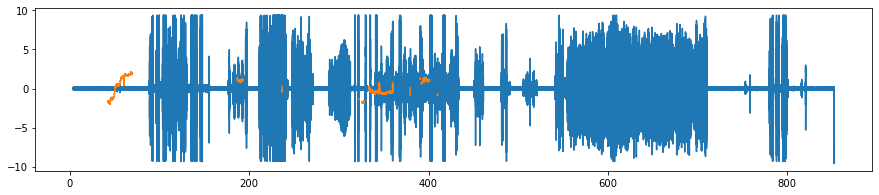

In [56]:
fig, axs = plt.subplots(figsize=(15,3))
axs.plot(timestamps,vol_z)
axs.plot(block.final_sync_df['Arena_TTL'].values/20000,re_el_z)

In [55]:
re_el_z = (block.re_df.ellipse_size - block.re_df.ellipse_size.mean()) / block.re_df.ellipse_size.std()
vol_z = (volume_trace - np.mean(volume_trace)) / np.std(volume_trace)

In [59]:
#def block_eye_plot(self, export=False, ms_x_axis=True, plot_saccade_locs=False,
#                  saccade_frames_l=None, saccade_frames_r=None):
# setup
ms_x_axis = True
export = True
plot_saccade_locs = False
saccade_frames_l = None
saccade_frames_r = None

# normalize values:
le_el_z = (block.le_df.ellipse_size - block.le_df.ellipse_size.mean()) / block.le_df.ellipse_size.std()
le_x_z = (block.le_df.center_x - np.mean(block.le_df.center_x)) / block.le_df.center_x.std()
le_y_z = (block.le_df.center_y - np.mean(block.le_df.center_y)) / block.le_df.center_y.std()
re_el_z = (block.re_df.ellipse_size - block.re_df.ellipse_size.mean()) / block.re_df.ellipse_size.std()
re_x_z = (block.re_df.center_x - np.mean(block.re_df.center_x)) / block.re_df.center_x.std()
re_y_z = (block.re_df.center_y - np.mean(block.re_df.center_y)) / block.re_df.center_y.std()
vol_z = (volume_trace - np.mean(volume_trace)) / np.std(volume_trace)

if ms_x_axis is False:
    x_axis = block.final_sync_df['Arena_TTL'].values
    b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                   x_axis_label='OE Timestamps',
                   y_axis_label='Z score',
                   plot_width=1500,
                   plot_height=700)
else:
    x_axis = (block.final_sync_df['Arena_TTL'].values -
              block.final_sync_df['Arena_TTL'].values[0]) / (block.sample_rate / 1000)
    b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                   x_axis_label='[Milliseconds]',
                   y_axis_label='[Z score]',
                   plot_width=1500,
                   plot_height=700)
b_fig.add_tools(HoverTool())
b_fig.line(x_axis, le_el_z+7, legend_label='Left Eye Diameter', line_width=1.5, line_color='blue')
#b_fig.line(x_axis, le_x_z+14, legend_label='Left Eye X Position', line_width=1, line_color='cyan')
#b_fig.line(x_axis, le_y_z, legend_label='Left Eye Y position', line_width=1, line_color='green')
b_fig.line(x_axis, re_el_z+7, legend_label='Right Eye Diameter', line_width=1.5, line_color='red')
#b_fig.line(x_axis, re_x_z+14, legend_label='Right Eye X Position', line_width=1, line_color='orange')
#b_fig.line(x_axis, re_y_z, legend_label='Right Eye Y position', line_width=1, line_color='pink')
b_fig.line(timestamps * 2000, vol_z)
if plot_saccade_locs:
    b_fig.vbar(x=saccade_frames_l, width=1, bottom=-4, top=-1,
               alpha=0.8, color='purple', legend_label='Left saccades')
    b_fig.vbar(x=saccade_frames_r, width=1, bottom=-4, top=-1,
               alpha=0.8, color='brown', legend_label='Right saccades')
if export:
    b_output.output_file(filename=str(block.analysis_path / f'pupillometry_block_{block.block_num}.html'),
                         title=f'block {block.block_num} pupillometry')
show(b_fig)

In [ ]:
# To generate the blocks:
block_numbers = [i for i in range(72,76)]
bad_blocks = []
blocklist = block_generator(block_numbers,pathlib.Path(r"Z:\Nimrod\experiments"),'PV_62',bad_blocks=bad_blocks, regev=True)
for block in blocklist:
    analyzed_block_automated_pipe(block)

In [17]:
#block definition
experiments_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = "PV_62"
date = "2023_06_21"
block_n = "073"

block = BlockSync(animal_call=animal,
                  experiment_date=date,block_num=block_n,
                  path_to_animal_folder=str(experiments_path),regev=True)
#analyzed_block_automated_pipe(block)

instantiated block number 073 at Path: Z:\Nimrod\experiments\PV_62\2023_06_21\block_073, new OE version
Found the sample rate for block 073 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 073
got it!


In [4]:
block = block_collection[1]

In [18]:
block.handle_eye_videos()
block.handle_arena_files()
block.parse_open_ephys_events()

handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_073\\eye_videos\\LE\\230621_pv62_audiostim2_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim2.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_073\\eye_videos\\RE\\230621_pv62_audiostim2_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim2.h264']
The file Z:\Nimrod\experiments\PV_62\2023_06_21\block_073\eye_videos\RE\230621_pv62_audiostim2_640x480_60hz_experiment_1_recording_0\230621_pv62_audiostim2.mp4 already exists, no conversion necessary
Validating videos...
The video named 230621_pv62_audiostim2_LE.mp4 has reported 68629 frames and has 68629 frames, it has dropped 0 frames
The video named 230621_pv62_audiostim2.mp4 has reported 68588 frames and has 68588 frames, it has dropped 0 frames
handling arena files
no arena timestamps folder found
Arena video Names:
back_20230621T144553.mp4
left_20230621T144553.mp4
right_20230621T144553.mp4
top_

In [27]:
block.create_arena_brightness_df(threshold_value=240,export=True)

no arena synchronization step performed - running it now...


ValueError: max() arg is an empty sequence

In [6]:
block.synchronize_block()

blocksync_df loaded from analysis folder


,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame
0,709902.0,519.0,8.0,0.0
1,710241.0,520.0,9.0,1.0
2,710581.0,521.0,10.0,2.0
3,710921.0,522.0,11.0,3.0
4,711261.0,523.0,12.0,4.0
...,...,...,...,...
126966,43855505.0,127485.0,129406.0,129599.0
126967,43855844.0,127486.0,129407.0,129600.0
126968,43856184.0,127487.0,129408.0,129602.0
126969,43856524.0,127488.0,129409.0,129603.0


In [19]:
dir(block.oe_rec)

['ADBitVolts',
 'MicrovoltsPerAD',
 'MicrovoltsPerADAnalog',
 'ZeroADValue',
 'ZeroADValueAnalog',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'allTimeStamps',
 'analogChannelNames',
 'analogChannelNumbers',
 'analog_files',
 'blkBytesCont',
 'blkBytesEvnt',
 'blkCont',
 'blkEvnt',
 'blockLength',
 'blockLengthAnalog',
 'bufferSize',
 'bufferSizeAnalog',
 'bytesPerRecCont',
 'bytesPerRecEvnt',
 'chLayoutNames',
 'chLayoutNumbers',
 'chLayoutPositions',
 'channelFiles',
 'channelFilesAnalog',
 'channelNames',
 'channelNumbers',
 'channelNumbersOrignal',
 'channel_files',
 'convertData2Double',
 'dataDescriptionCont',
 'dataDescriptionContAnalog',
 'dataDescriptionEv

In [21]:
block.oe_rec.analog_files

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_C1-AUX3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous']

In [8]:
block.create_eye_brightness_df(threshold_value=20)

eye_brightness_df loaded from analysis folder


,Unnamed: 0,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,0,709902.0,519.0,8.0,0.0,-1.097129,-1.960057
1,1,710241.0,520.0,9.0,1.0,-1.096889,-1.960464
2,2,710581.0,521.0,10.0,2.0,-1.097874,-1.960933
3,3,710921.0,522.0,11.0,3.0,-1.098723,-1.961018
4,4,711261.0,523.0,12.0,4.0,-1.100564,-1.961210
...,...,...,...,...,...,...,...
126966,126966,43855505.0,127485.0,129406.0,129599.0,-0.466905,-0.174027
126967,126967,43855844.0,127486.0,129407.0,129600.0,-0.467561,-0.174859
126968,126968,43856184.0,127487.0,129408.0,129602.0,-0.466926,-0.174593
126969,126969,43856524.0,127488.0,129409.0,129603.0,-0.465842,-0.175048


In [9]:
block.get_eyes_diff_list(threshold=2)

index error on position 17 out of 18
index error on position 47 out of 48
The suspected lag between eye cameras is -24.0 with the direction ['right', 'early']


In [21]:
block.fix_eye_synchronization()

created manual_sync_df attribute for the block


In [22]:
block.get_blink_frames_manual(threshold=2.5)

index error on position 10 out of 11
index error on position 46 out of 47


{'left': [2064.0,
  9281.0,
  12890.0,
  16499.0,
  20107.0,
  23716.0,
  27324.0,
  30933.0,
  34542.0,
  38150.0,
  41759.0,
  45367.0,
  48976.0,
  52585.0,
  56193.0,
  59802.0,
  63411.0,
  67019.0,
  70629.0,
  74236.0,
  77845.0,
  81453.0,
  85062.0,
  88671.0,
  92279.0,
  95888.0,
  99496.0,
  103105.0,
  106714.0,
  110322.0,
  113931.0,
  117539.0,
  121148.0,
  124757.0],
 'right': [2072.0,
  5681.0,
  9257.0,
  12866.0,
  16474.0,
  20083.0,
  23692.0,
  27300.0,
  30888.0,
  37958.0]}

In [23]:
block.manual_sync_df

,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,709902.0,519.0,8.0,NaN,-1.097129,NaN
1,710241.0,520.0,9.0,NaN,-1.096889,NaN
2,710581.0,521.0,10.0,NaN,-1.097874,NaN
3,710921.0,522.0,11.0,NaN,-1.098723,NaN
4,711261.0,523.0,12.0,NaN,-1.100564,NaN
...,...,...,...,...,...,...
126966,43855505.0,127485.0,129406.0,129575.0,-0.466905,-0.173107
126967,43855844.0,127486.0,129407.0,129576.0,-0.467561,-0.173247
126968,43856184.0,127487.0,129408.0,129577.0,-0.466926,-0.173749
126969,43856524.0,127488.0,129409.0,129578.0,-0.465842,-0.173566


In [29]:
# use this to manually shift L\R eye synchronization
eye_to_move = 'L'
block.move_eye_sync_manual(cols_to_move=[f'{eye_to_move}_eye_frame',f'{eye_to_move}_values'],step=+7)

In [30]:
block.full_sync_verification(with_arena=False)

In [31]:
block.export_manual_sync_df()

In [10]:
block.import_manual_sync_df()

In [ ]:
block.read_dlc_data()

c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 130083/130083 [01:15<00:00, 1726.86it/s]



 Done


  0%|          | 21/126971 [00:00<11:00, 192.17it/s]


 Done
populating le_df


  0%|          | 26/126971 [00:00<16:06, 131.41it/s]

populating re_video_sync_df


100%|██████████| 126971/126971 [32:31<00:00, 65.06it/s]


done
exporting to analysis folder


In [1]:
block.block_eye_plot(ms_x_axis=True)

NameError: name 'block' is not defined

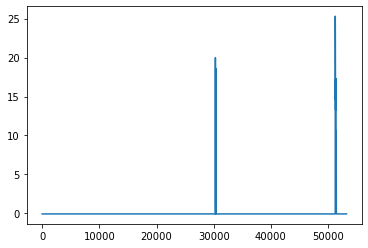

In [14]:
fig, axs = plt.subplots()
#axs.plot(np.diff(block.eye_brightness_df.R_values.values))
axs.plot(block.eye_brightness_df.R_values.values)
#axs.set_ylim(-1,1)

In [8]:
block.synchronize_arena_timestamps()

arena_sync_df already exists, loading from file...


In [33]:
r_rising = block.blink_rising_edges_detector(block.eye_brightness_df['L_values'].values,
                                            block.eye_brightness_df['L_eye_frame'], threshold=-4)
b_series = pd.Series(data=block.eye_brightness_df['R_values'].values, index=block.eye_brightness_df['R_eye_frame'])
blink_indexes = b_series[b_series < -4].index


index error on position 122 out of 123


[631.0,
 3050.0,
 3131.0,
 5955.0,
 6739.0,
 10348.0,
 10421.0,
 12752.0,
 13956.0,
 15541.0,
 17565.0,
 17728.0,
 21174.0,
 22643.0,
 24782.0,
 26873.0,
 28391.0,
 28412.0,
 29880.0,
 31999.0,
 32344.0,
 34322.0,
 35608.0,
 36829.0,
 37478.0,
 39216.0,
 39564.0,
 40480.0,
 42825.0,
 43102.0,
 45899.0,
 46434.0,
 47936.0,
 47940.0,
 49513.0,
 50042.0,
 51423.0,
 53651.0]

In [16]:
#Test oe_events_parser:
# initialize variables
open_ephys_csv_path = block.block_path / rf'oe_files' / block.exp_date_time / 'events.csv'
channel_names = block.channeldict
arena_channel_name='Arena_TTL'
export_path=None

# infer the active channels:
df = pd.read_csv(open_ephys_csv_path)
channels = np.unique(df['line'].to_numpy(copy=True))
df_onstate = df[df['state'] == 1]  # cut the df to represent only rising edges
ls = []
for chan in channels:  # extract a pandas series of the ON stats timestamps for each channel
    if chan in channel_names.keys():
        sname = channel_names[chan]
        s = pd.Series(df_onstate['sample_number'][df_onstate['line'] == chan], name=sname)
        # If this is the arena channel we need to collect the first and last frames which correspond with
        # the video itsef (as TTLs are always being transmitted and a pause is expected before the video starts
        if sname == arena_channel_name:
            diff_series = np.diff(s)
            diff_mode = stats.mode(diff_series)[0][0]
            arena_start_stop = np.where(diff_series > 10 * diff_mode)[0]
            if len(arena_start_stop) != 2:
                start_ind = input(f'there is some kind of problem because there should be 2 breaks in the arena TTLs'
                        f'and there are {len(arena_start_stop)}, those indices are: {[s.iloc[i] for i in arena_start_stop]}... '
                                  f'choose the index to use as startpoint:')
                end_ind = input('choose the index to use as endpoint:')
                arena_start_timestamp = s.iloc[arena_start_stop[int(start_ind)] + 1]
                print(f'arena first frame timestamp: {arena_start_timestamp}')
                arena_end_timestamp = s.iloc[arena_start_stop[int(end_ind)]]
                print(f'arena end frame timestamp: {arena_end_timestamp}')
            else:
                print(f'the arena TTLs are signaling start and stop positions at {arena_start_stop}')
                arena_start_timestamp = s.iloc[arena_start_stop[0] + 1]
                print(f'arena first frame timestamp: {arena_start_timestamp}')
                arena_end_timestamp = s.iloc[arena_start_stop[1]]
                print(f'arena end frame timestamp: {arena_end_timestamp}')
        else:
            print(f'{sname} was not identified as {arena_channel_name}')
        # create a counter for every rising edge - these should match video frames
        s_counter = pd.Series(data=np.arange(len(s), dtype='Int32'), index=s.index.values, name=sname+'_frame')
        ls.append(s)
        ls.append(s_counter)
# concatenate all channels into a dataframe with open-ephys compatible timestamps
open_ephys_events = pd.concat(ls, axis=1)
# use arena start_stop to clean TTLs counted before video starts and after video ends
open_ephys_events[f'{arena_channel_name}_frame'] = open_ephys_events[f'{arena_channel_name}_frame'] - (
            arena_start_stop[0] + 1)
open_ephys_events[f'{arena_channel_name}_frame'][open_ephys_events[f'{arena_channel_name}_frame'] < 0] = np.nan
open_ephys_events[f'{arena_channel_name}_frame'][
open_ephys_events[f'{arena_channel_name}'] > arena_end_timestamp] = np.nan

if export_path is not None:
    if export_path not in os.listdir(str(open_ephys_csv_path).split('events.csv')[0][:-1]):
        open_ephys_events.to_csv(export_path)


the arena TTLs are signaling start and stop positions at [ 1661 24692]
arena first frame timestamp: 1074086
arena end frame timestamp: 8896453
LED_driver was not identified as Arena_TTL
L_eye_TTL was not identified as Arena_TTL
R_eye_TTL was not identified as Arena_TTL


<ipython-input-16-2685f8107403>:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  s_counter = pd.Series(data=np.arange(len(s), dtype='Int32'), index=s.index.values, name=sname+'_frame')
<ipython-input-16-2685f8107403>:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  s_counter = pd.Series(data=np.arange(len(s), dtype='Int32'), index=s.index.values, name=sname+'_frame')
<ipython-input-16-2685f8107403>:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  s_counter = pd.Series(data=np.arange(len(s), dtype='Int32'), index=s.index.values, name=sname+'_frame')
<ipython-input-16-2685f8107403>:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  s_counter = pd.Series(data=np.arange(len(s), dtype='Int32'), index=s.index.values, name=sname+'_frame')


In [7]:

for vid in block.arena_videos:
    cap = cv2.VideoCapture(str(vid))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f'The video named {os.path.split(vid)[1]} has {length} frames')
    cap.release()

The video named back_20230502T134223.mp4 has 53936 frames
The video named left_20230502T134223.mp4 has 53935 frames
The video named right_20230502T134223.mp4 has 53936 frames
The video named top_20230502T134223.mp4 has 53933 frames


In [153]:
# synchronize arena timestamps with the new system:
# The problem = number of frames does not align with number of ttls transmitted by the arduino + different cameras take different number of frames
# solution:
# 1. go through the csv files to see real frame-counts vs actual frames gathered
#arena_timestamps = [i for i in glob.glob(block.arena_files[0].parent / 'frame_timestamps')]
#arena_timestamps
arena_timestamp_files = [i for i in (block.arena_files[0].parent / 'frames_timestamps').iterdir()]
# read the timestamp files
len_list = []
df_list = []
for p in arena_timestamp_files:
    if p.name != 'events.csv':
        df = pd.read_csv(p, index_col=0)
        df  = df.rename(columns={'0':'timestamp'})
        df_list.append(df)
        len_list.append(len(df))

# pick the longest as anchor
anchor_ind = len_list.index(max(len_list))
anchor_vid = df_list[anchor_ind]

In [154]:
anchor_vid_name = block.arena_vidnames[anchor_ind]
block.arena_sync_df = pd.DataFrame(data=[],
                                  columns=block.arena_vidnames,
                                  index=range(len(anchor_vid)))
block.arena_sync_df[block.arena_sync_df.columns[anchor_ind]] = range(len(anchor_vid))
vids_to_sync = list(block.arena_sync_df.drop(axis=1, labels=anchor_vid_name).columns)
anchor_vid_df = df_list.pop(anchor_ind)
df_to_sync = df_list
print('Synchronizing the different arena videos')
for row in tqdm(block.arena_sync_df.index):
    anchor = anchor_vid.timestamp[row]
    for vid in range(len(df_to_sync)):
        frame_num = block.get_closest_frame(anchor, df_to_sync[vid])
        block.arena_sync_df.loc[row, vids_to_sync[vid]] = frame_num
print(f'The anchor video used was "{block.anchor_vid_name}"')

  0%|          | 46/91552 [00:00<06:41, 228.12it/s]

Synchronizing the different arena videos


100%|██████████| 91552/91552 [07:10<00:00, 212.69it/s]

The anchor video used was "None"
